## 1- Importing libraries

In [1]:
import os
import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr
import math
import warnings


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

rcParams['figure.figsize'] = 13, 6 
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2- Loading dataset

In [2]:
# Loading data with FinanceDataReader
df_btc = fdr.DataReader('BTC/KRW', '2000')
print(df_btc.shape)
print(type(df_btc))
df_btc.tail()

(3486, 6)
<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-29,93797536.0,96552184.0,92797392.0,95540848.0,95540848.0,46423202325089
2024-03-30,95540640.0,95642944.0,92932128.0,94096712.0,94096712.0,33968295728007
2024-03-31,94097544.0,94719600.0,93703912.0,93763472.0,93763472.0,23062444646553
2024-04-01,93766808.0,96025272.0,93735960.0,95965904.0,95965904.0,26974741462504
2024-04-02,94499552.0,94499552.0,89827344.0,90396480.0,90396480.0,54631837204480


In [3]:
# Extracting the 'Close' column
btc = df_btc['Close']
print(type(btc))
btc.tail()

<class 'pandas.core.series.Series'>


Date
2024-03-29    95540848.0
2024-03-30    94096712.0
2024-03-31    93763472.0
2024-04-01    95965904.0
2024-04-02    90396480.0
Name: Close, dtype: float64

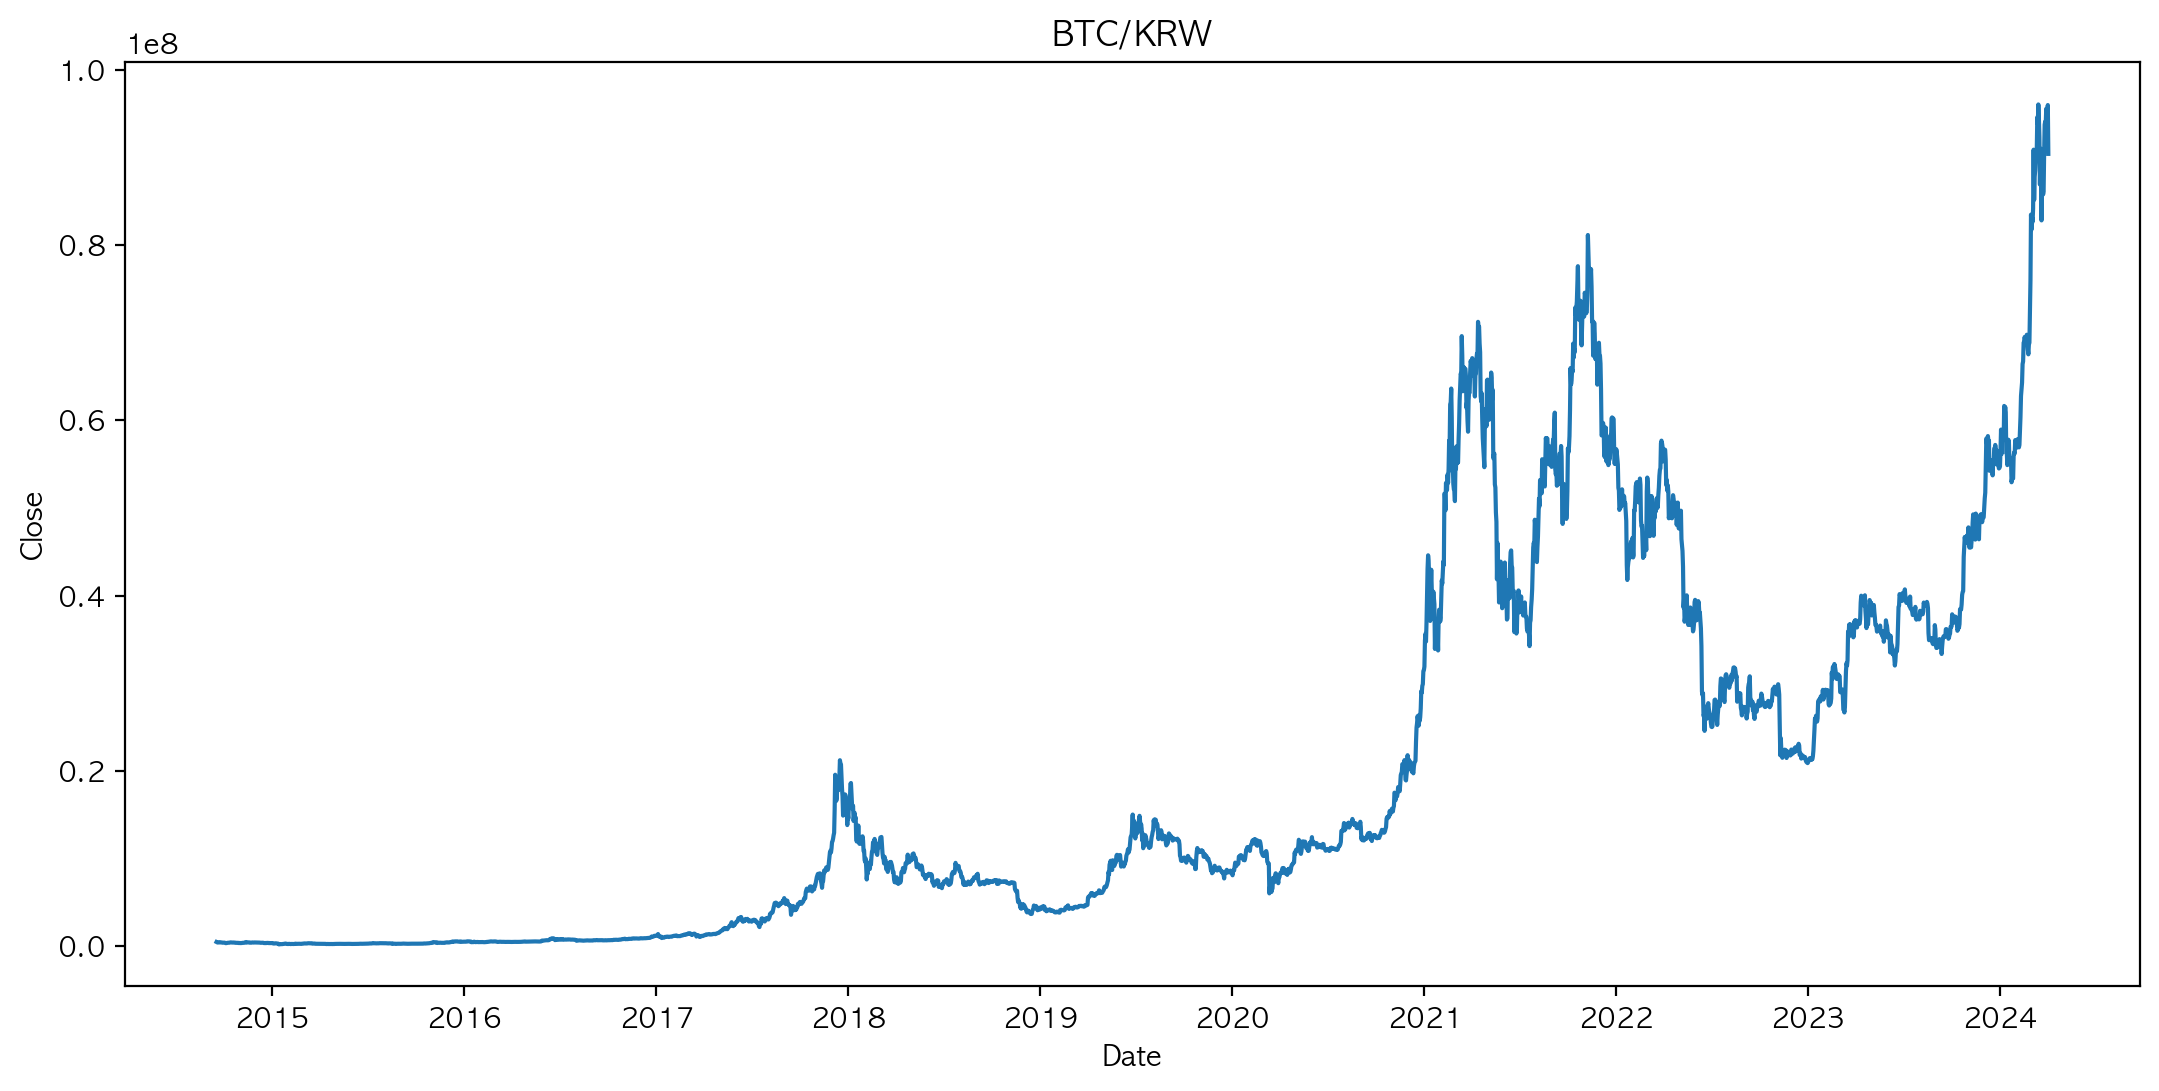

In [4]:
# Plotting the loaded dataset
sns.lineplot(data=btc)
plt.title('BTC/KRW')
plt.show()

## 3- Handling missing value

In [5]:
btc = btc.interpolate(method = 'time')
print(btc[btc.isna()])

Series([], Name: Close, dtype: float64)


In [6]:
btc.isnull().sum()

0

## 4- Log transformation

<Axes: xlabel='Date', ylabel='Close'>

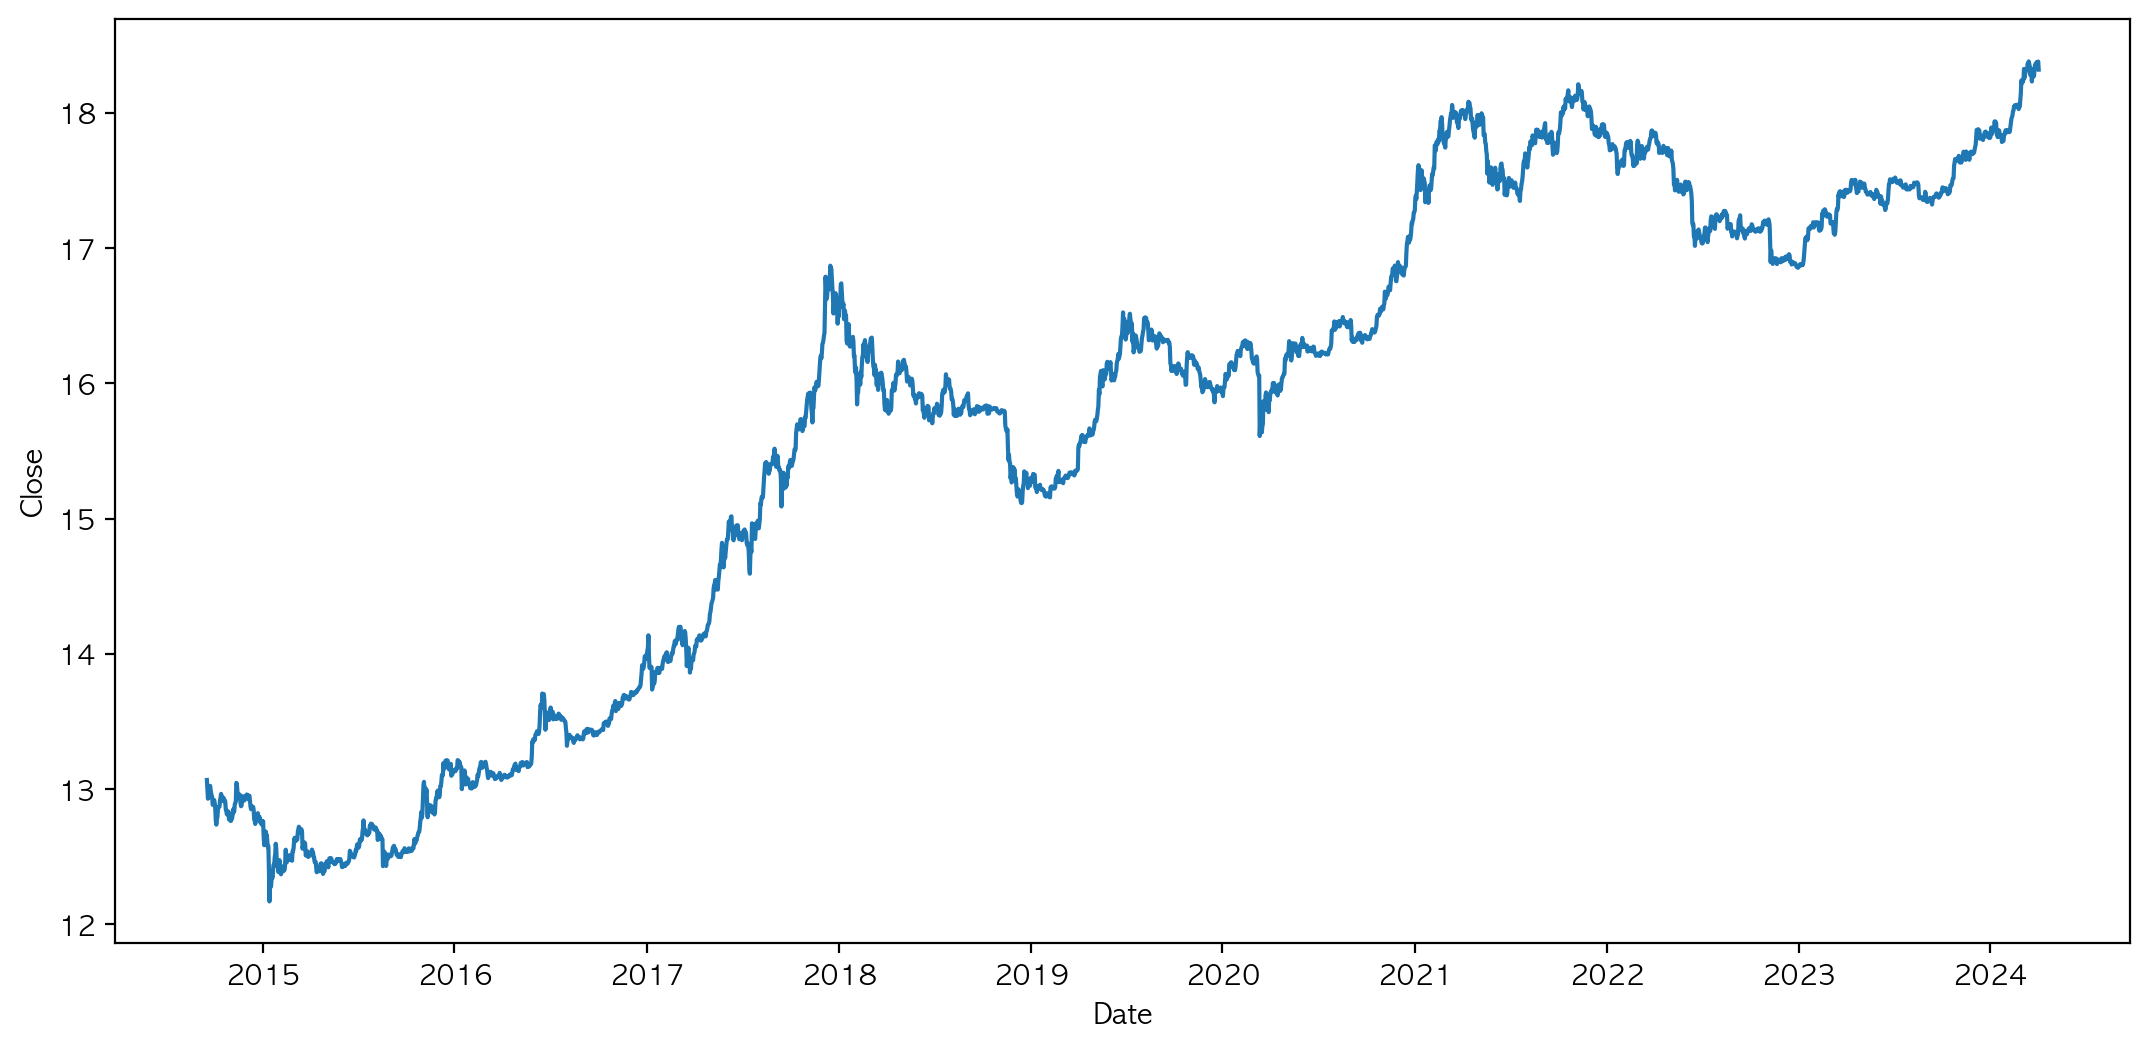

In [7]:
# Log transformation
btc_log = np.log(btc)
sns.lineplot(data=btc_log)

## 5- Moving average

In [8]:
# Rolling mean and standard deviation
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
def rolling_ts(timeseries, window):

    rollmean = btc.rolling(window = window).mean()  # moving average time series
    rollstd = btc.rolling(window = window).std()  # moving standard deviation time series

    plt.plot(btc, color = 'blue', label = 'Original')
    plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rollstd, color = 'black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.legend(loc = 'best')
    plt.grid(True)

Date
2014    106
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024     93
Name: Close, dtype: int64

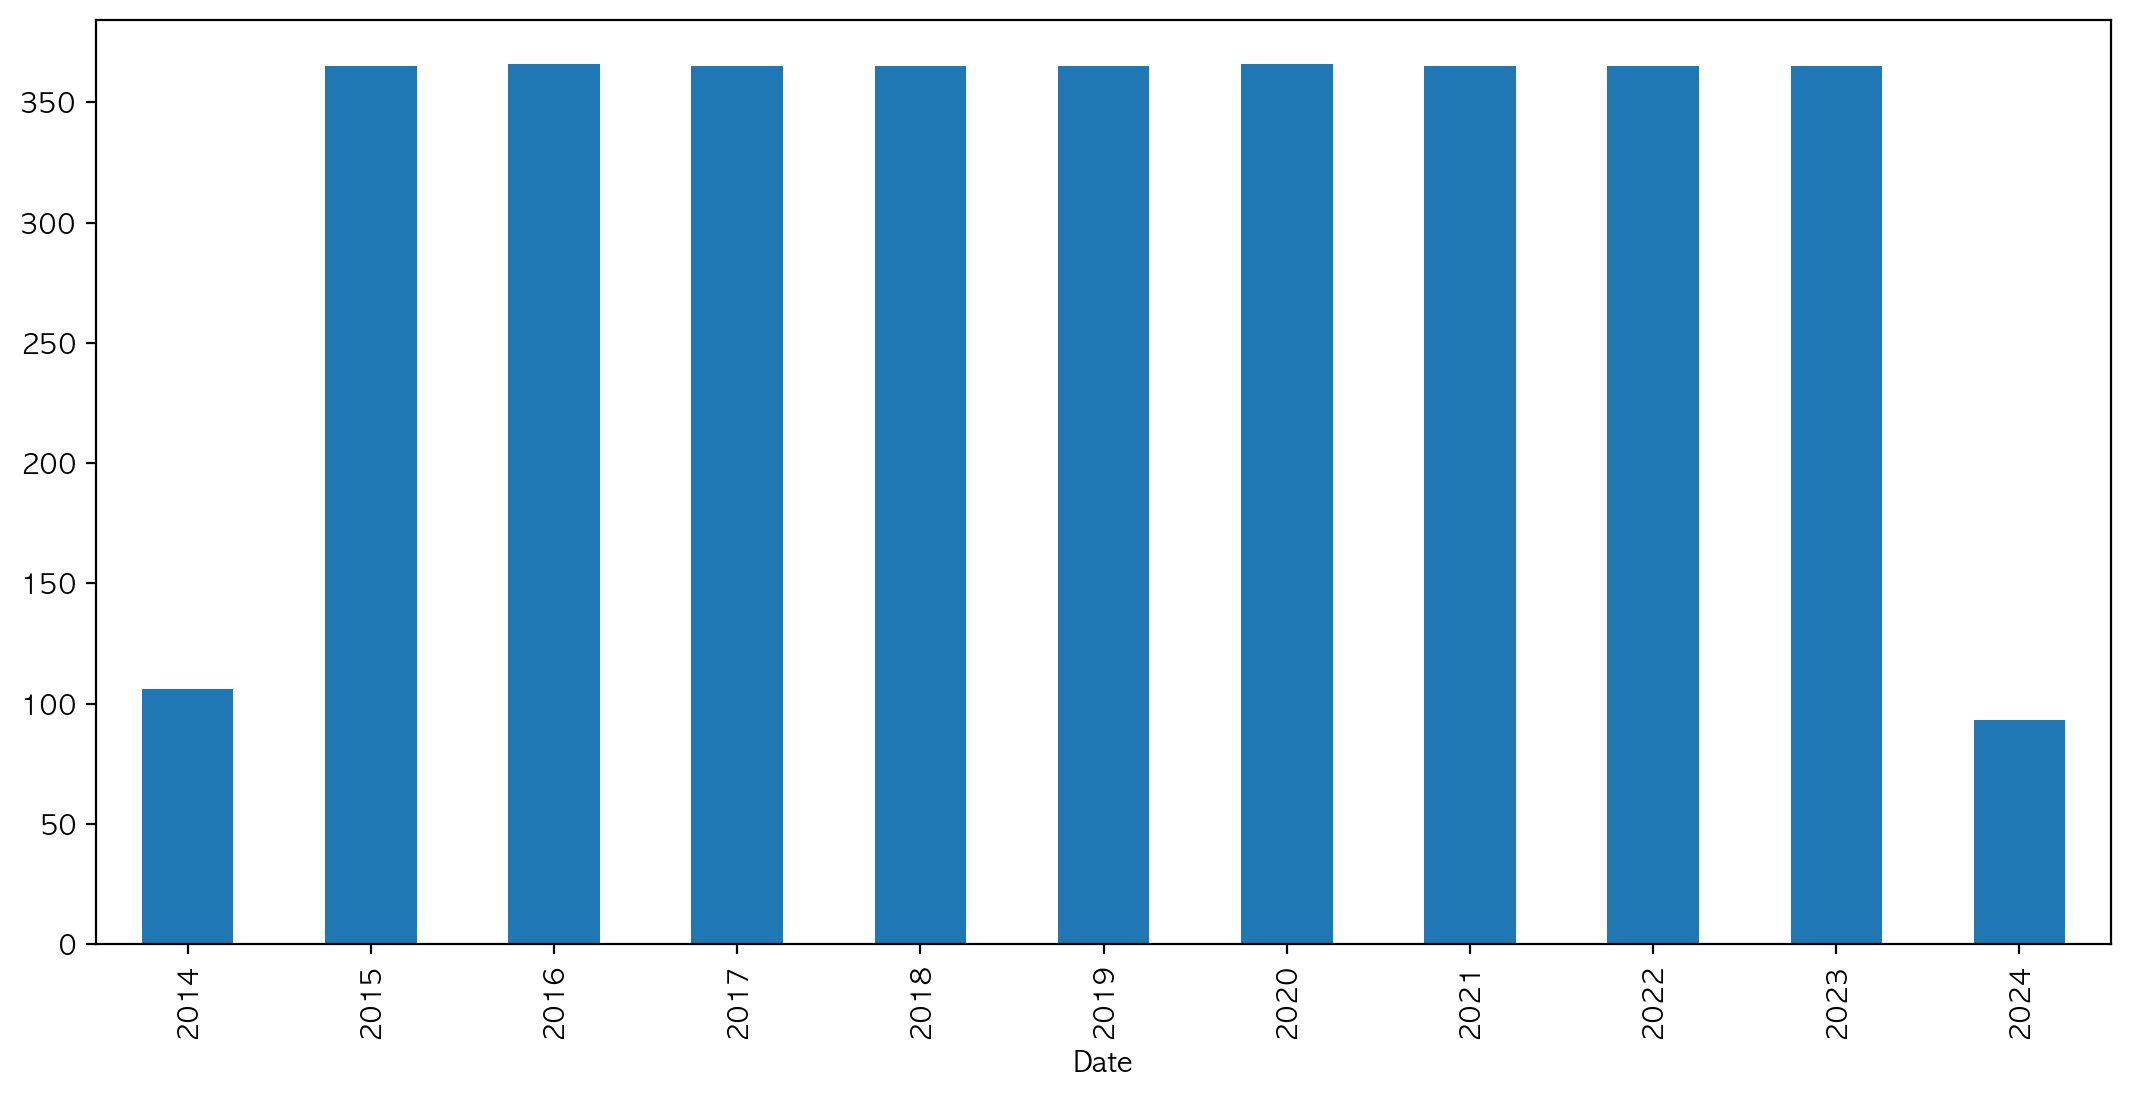

In [9]:
btc.groupby(btc.index.year).count().plot(kind='bar')
btc.groupby(btc.index.year).count()

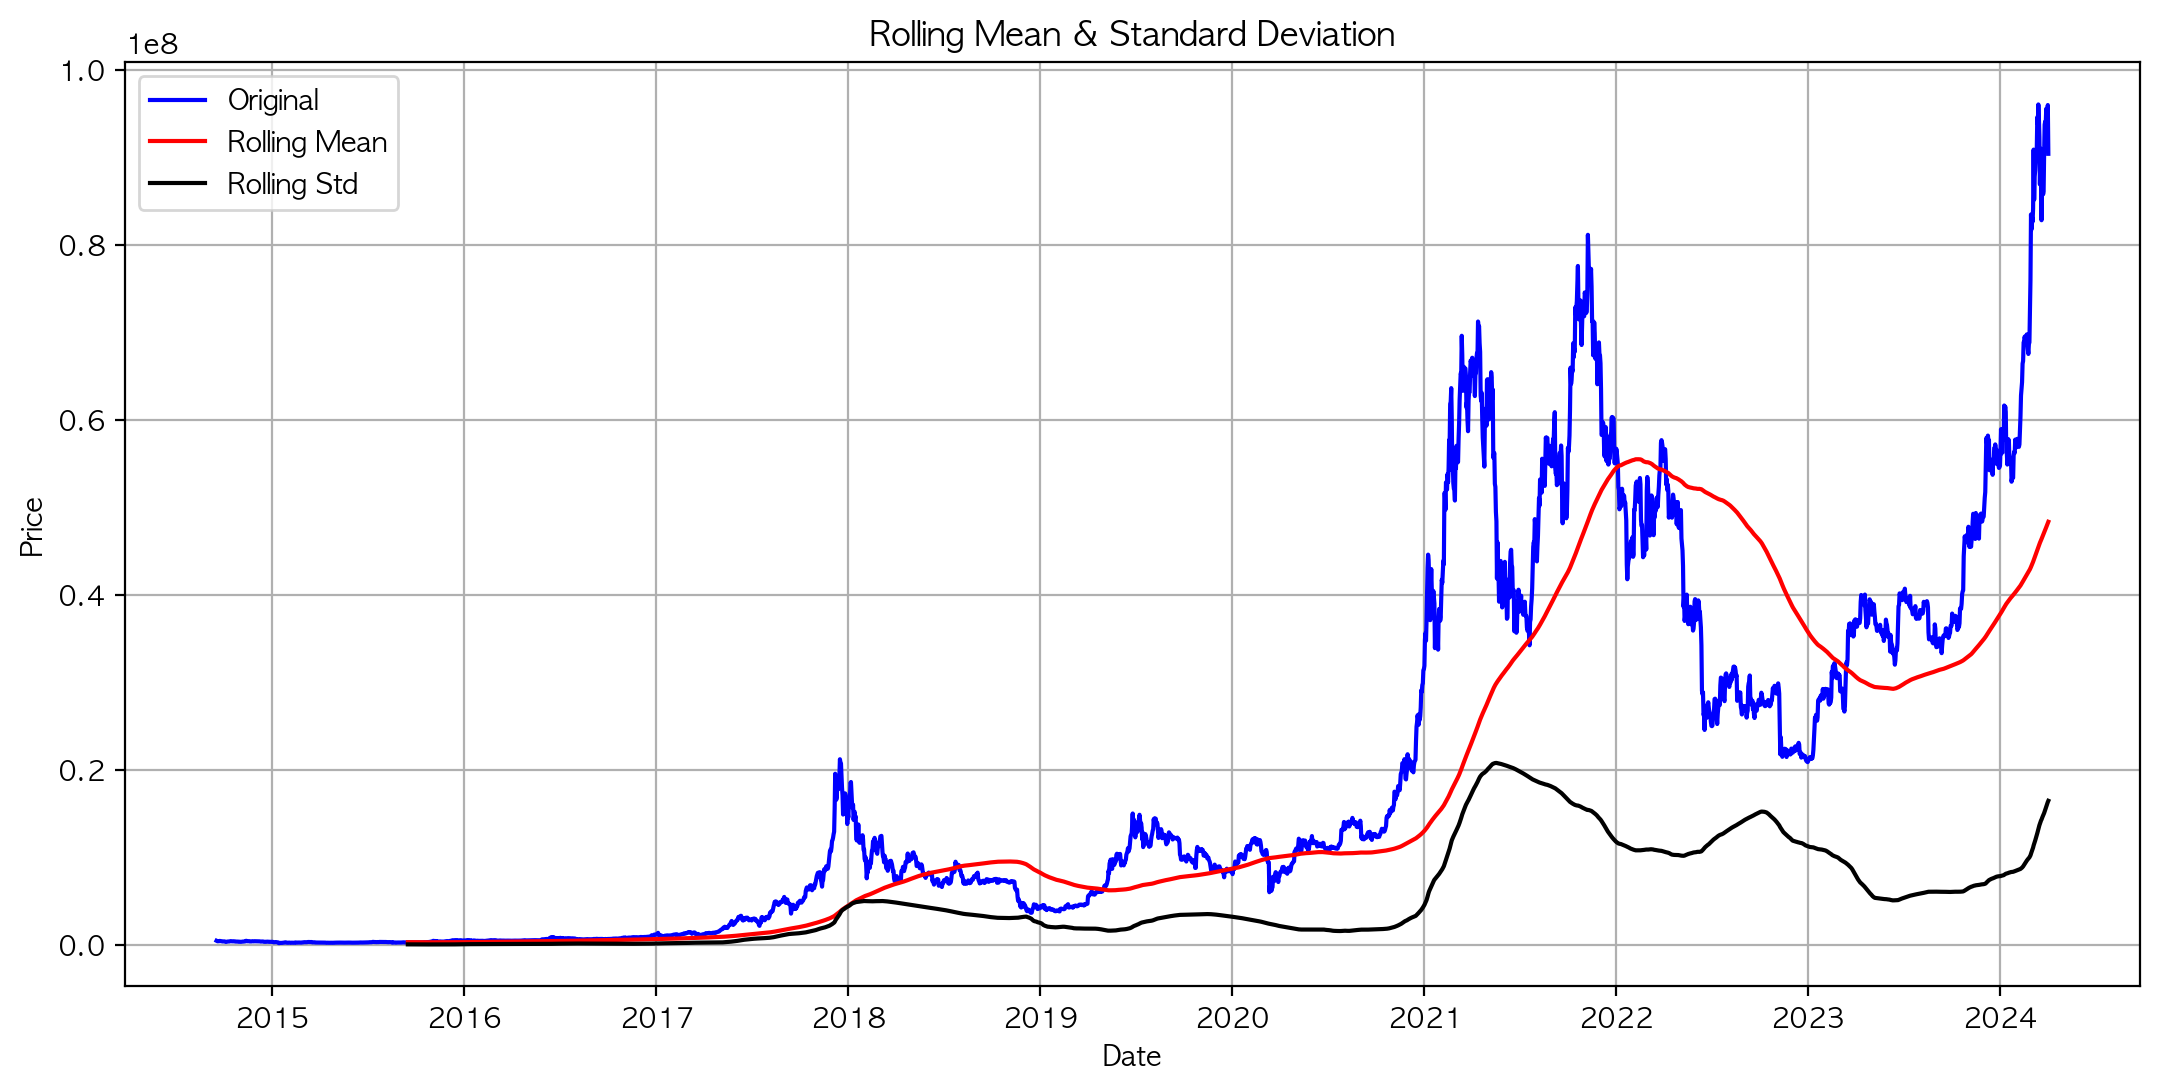

In [10]:
rolling_ts(btc, 365)

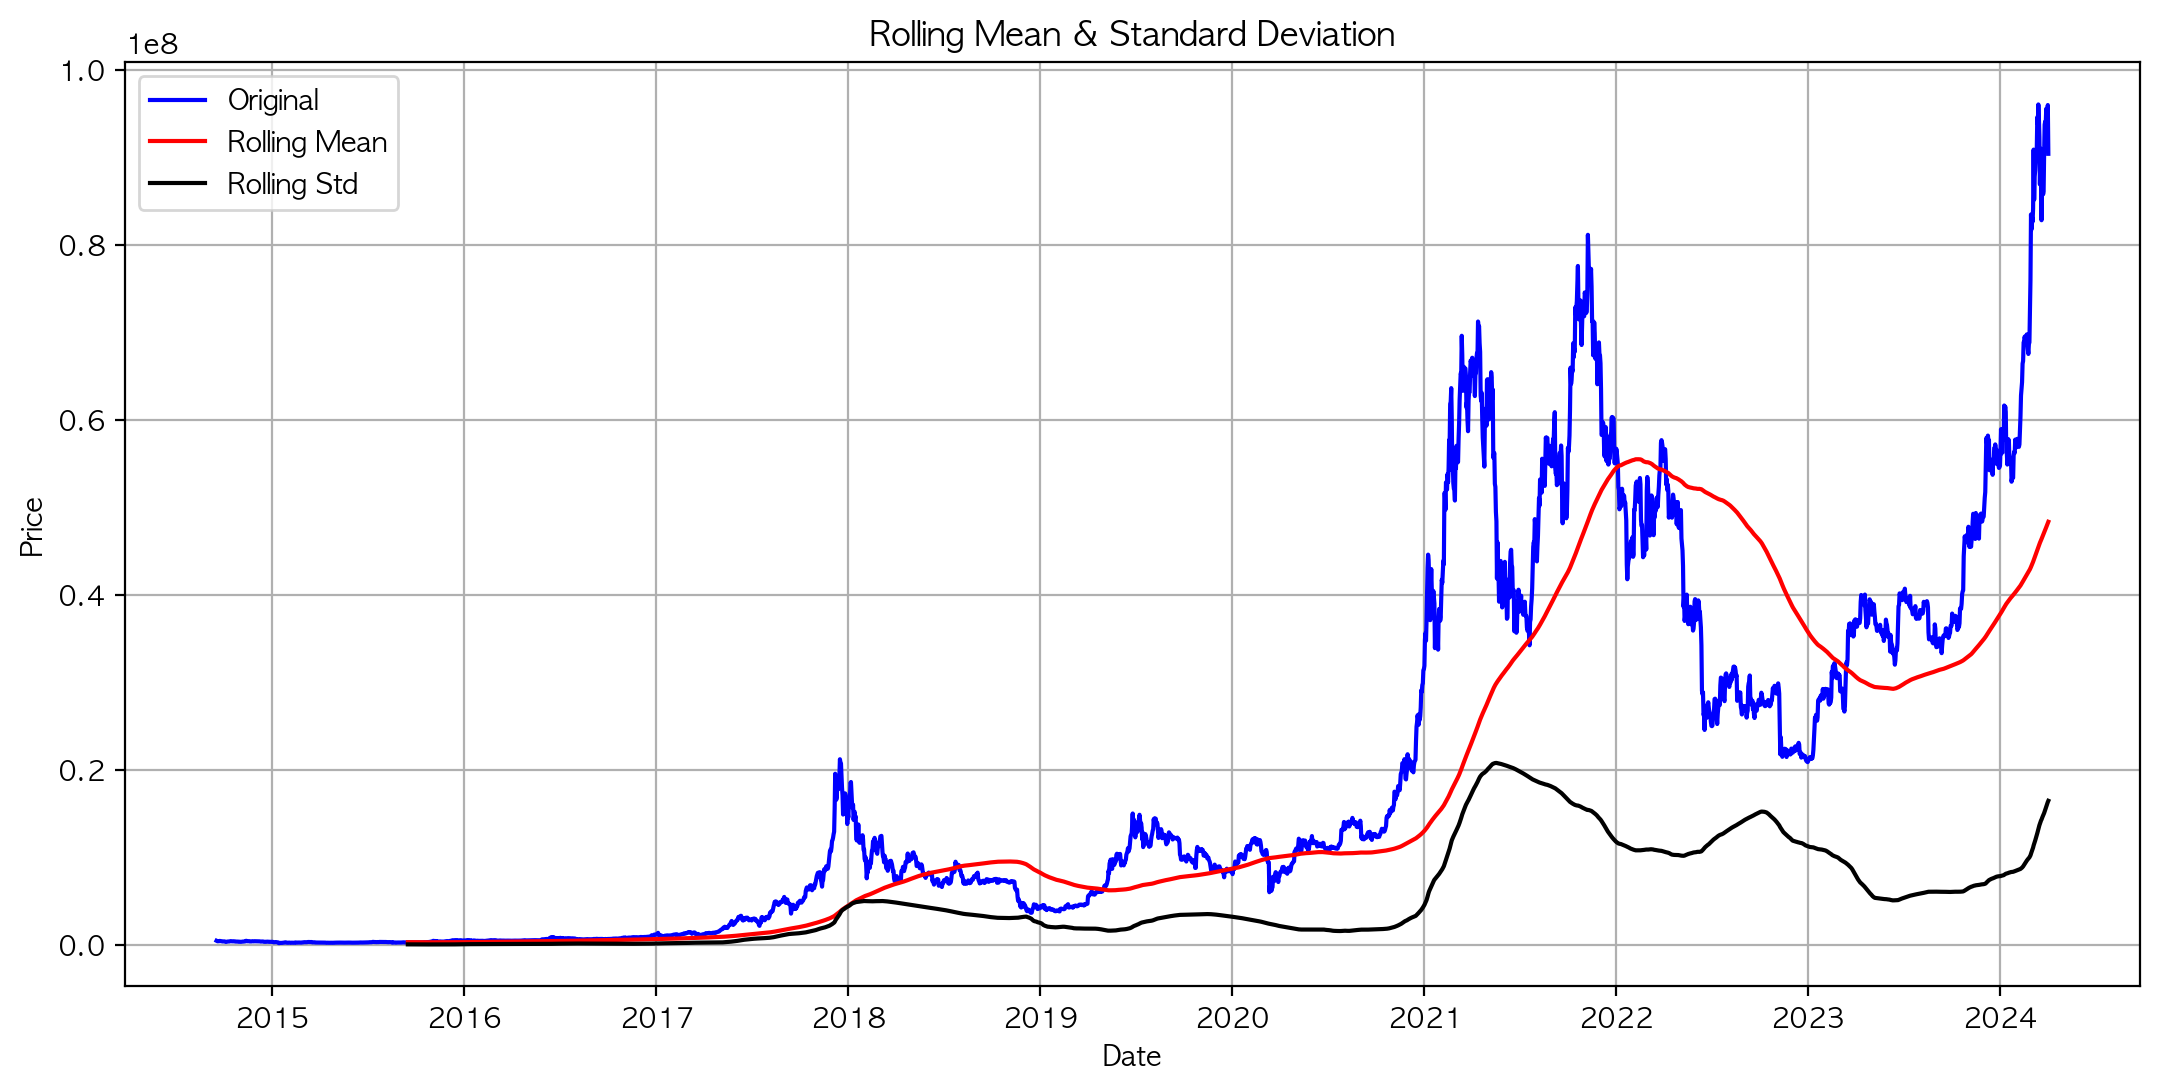

In [11]:
rolling_ts(btc_log, 365)

## 6- Time series decomposition

In [12]:
# Decomposition of time series
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
def decomposition_ts(timeseries, period, name):

    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(timeseries, model = 'multiplicative', period = period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label = 'Origianl', color = 'purple')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.title(f'Decomposition of Time Series : ({timeseries.name}) of ({name}) in period ({period})')

    plt.subplot(412)
    plt.plot(trend, label = 'Trend', color = 'blue')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonality', color = 'green')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.subplot(414)
    plt.plot(residual, label = 'Residuals', color = 'orange')
    plt.legend(loc = 'best')
    plt.grid(True)
    
    plt.tight_layout()

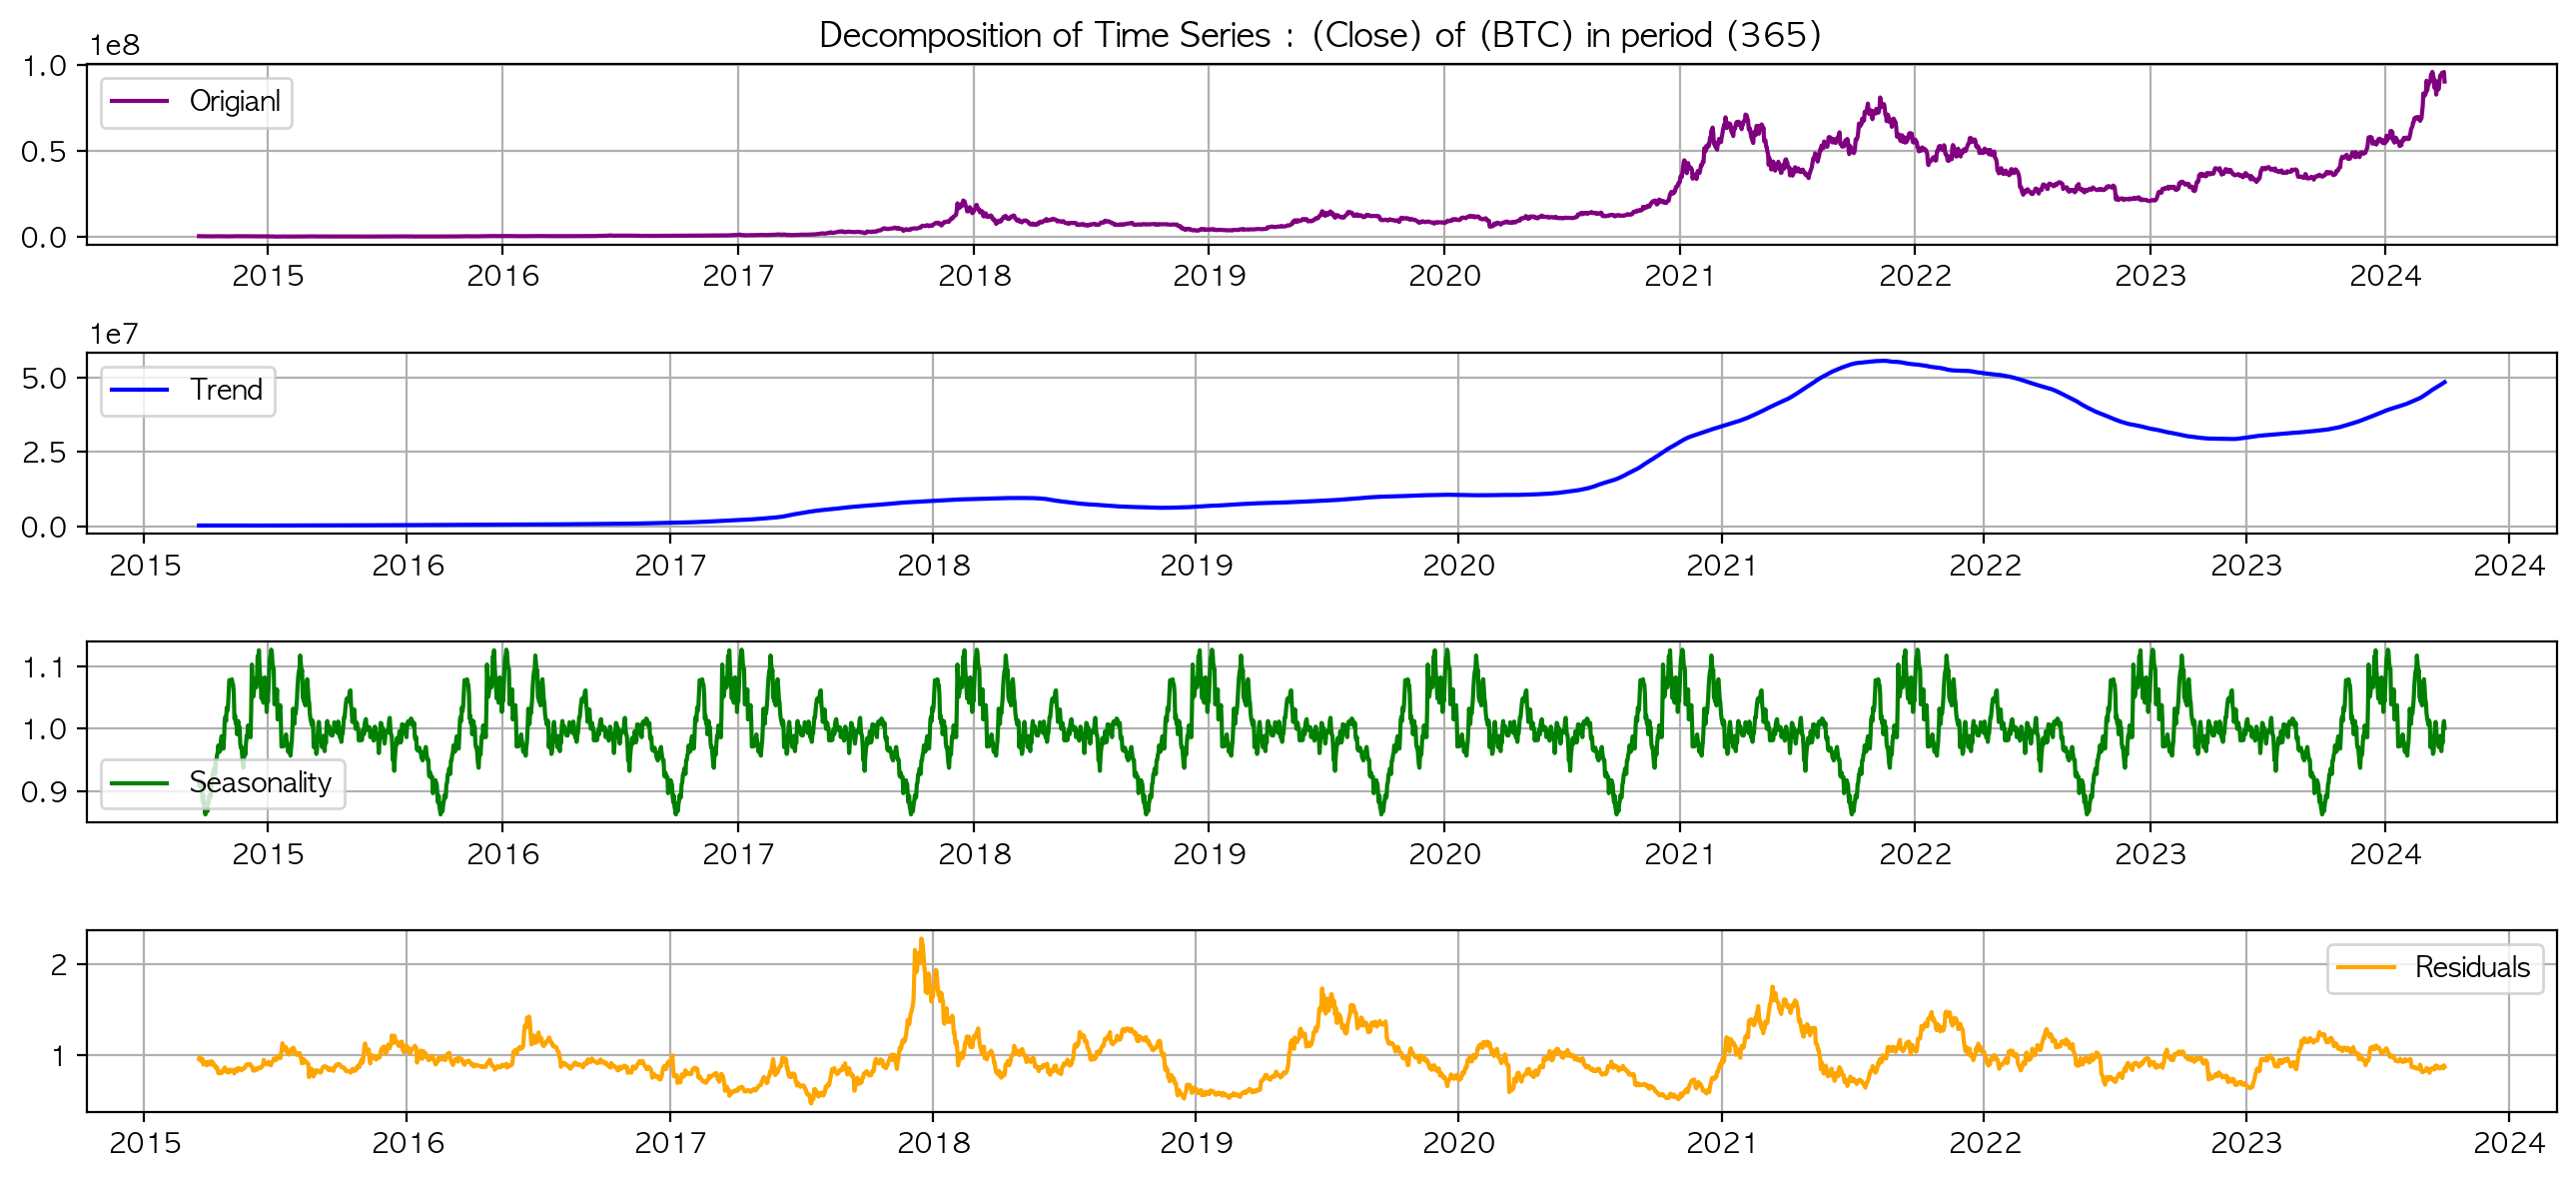

In [13]:
decomposition_ts(btc, 365, 'BTC')

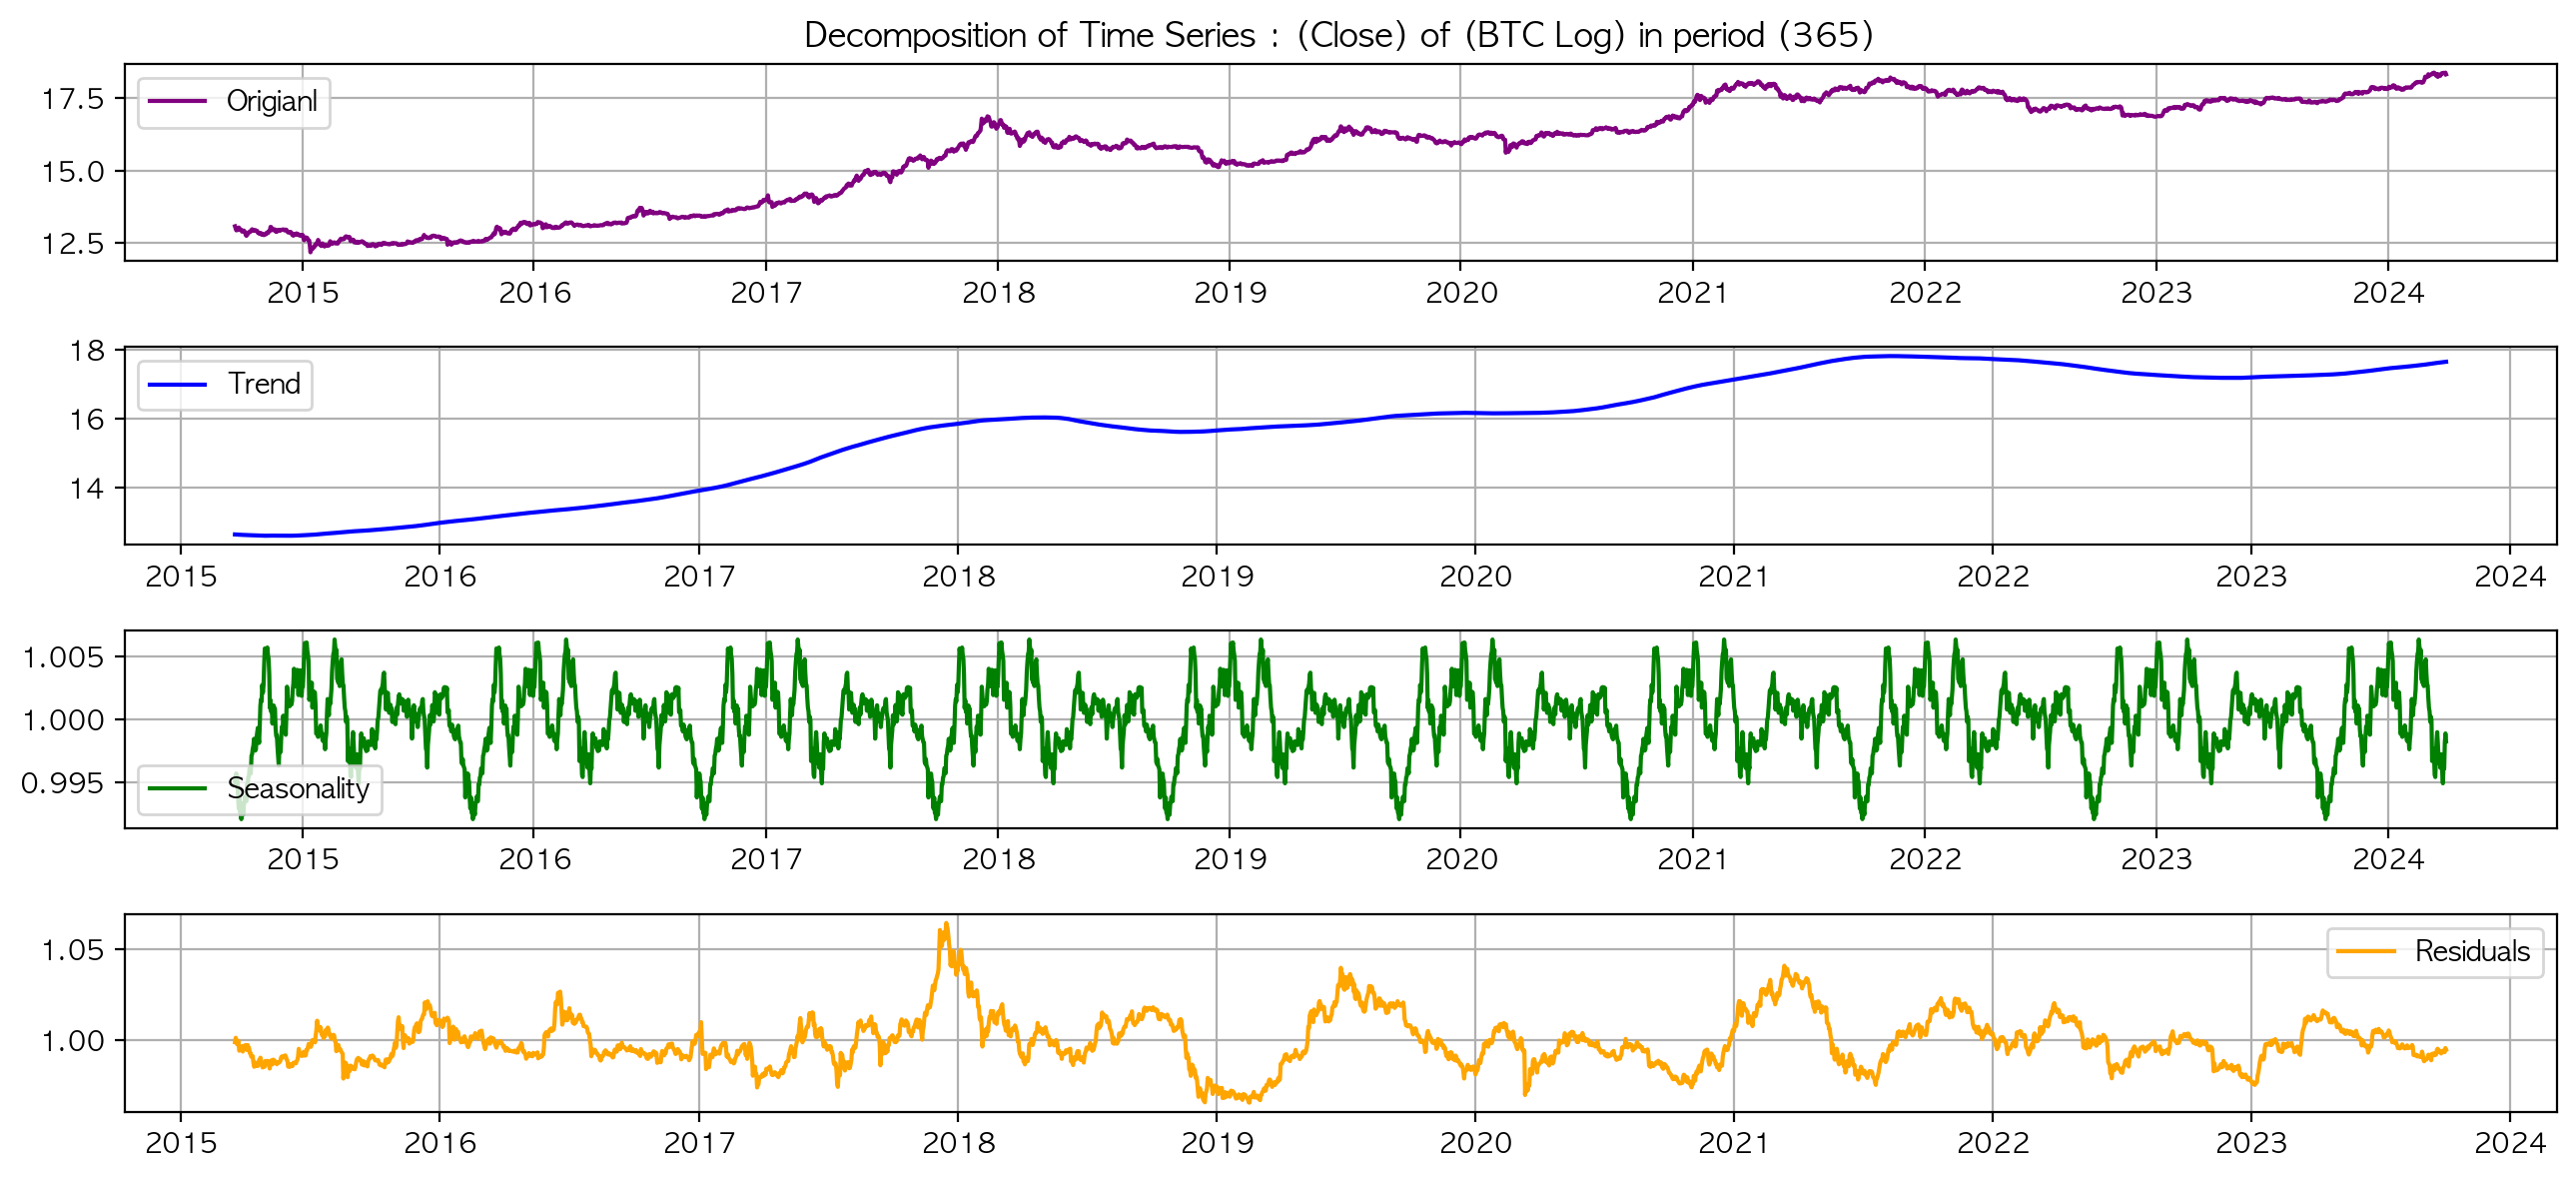

In [14]:
decomposition_ts(btc_log, 365, 'BTC Log')

## 7- ADF test

In [17]:
# Augmented Dickey-Fuller Test
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
def adf_ts(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [18]:
adf_ts(btc)

Results of Dickey-Fuller Test:
Test Statistic                   -0.082675
p-value                           0.951137
#Lags Used                       29.000000
Number of Observations Used    3456.000000
Critical Value (1%)              -3.432244
Critical Value (5%)              -2.862377
Critical Value (10%)             -2.567215
dtype: float64


In [19]:
adf_ts(btc_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.753012
p-value                           0.832536
#Lags Used                       10.000000
Number of Observations Used    3475.000000
Critical Value (1%)              -3.432233
Critical Value (5%)              -2.862372
Critical Value (10%)             -2.567213
dtype: float64


## 8- ACF/PACF plot

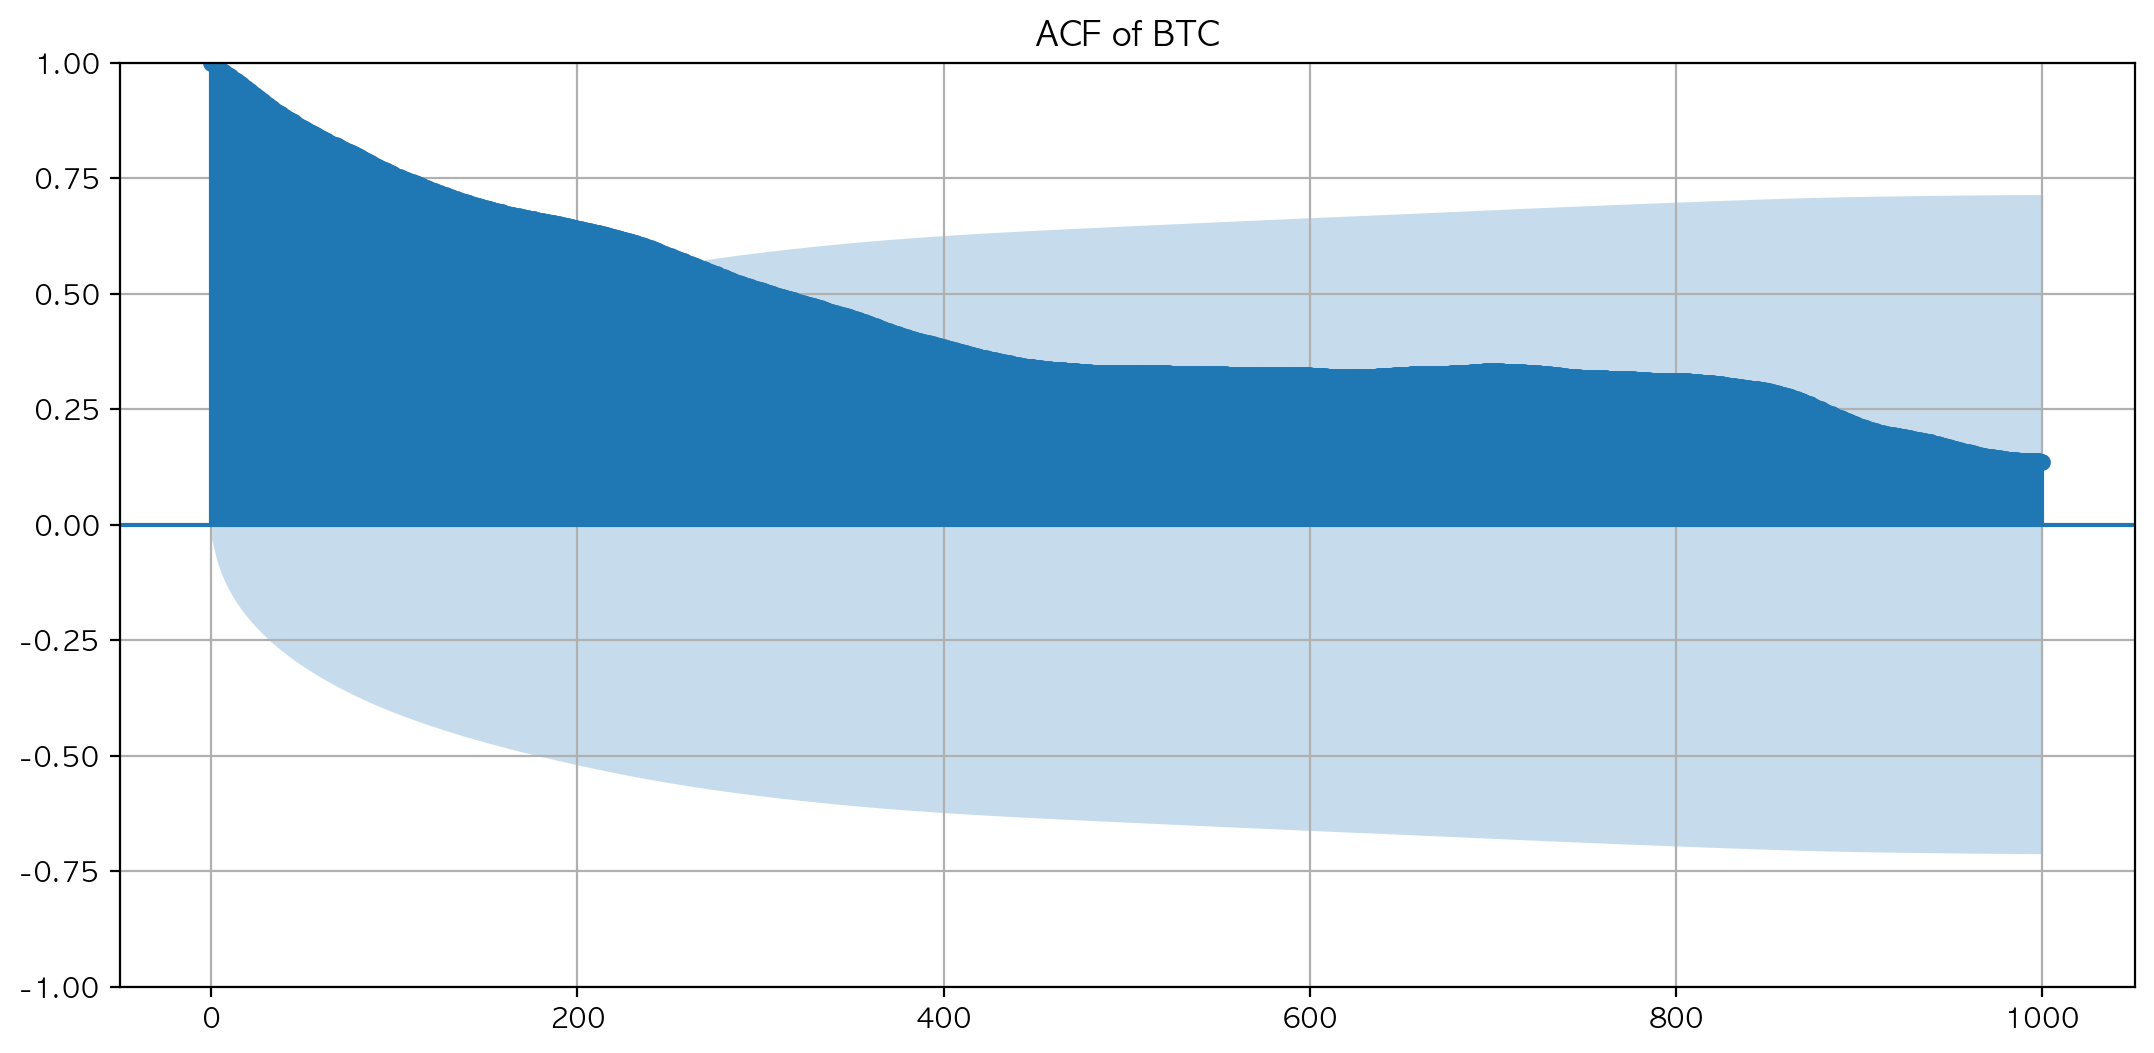

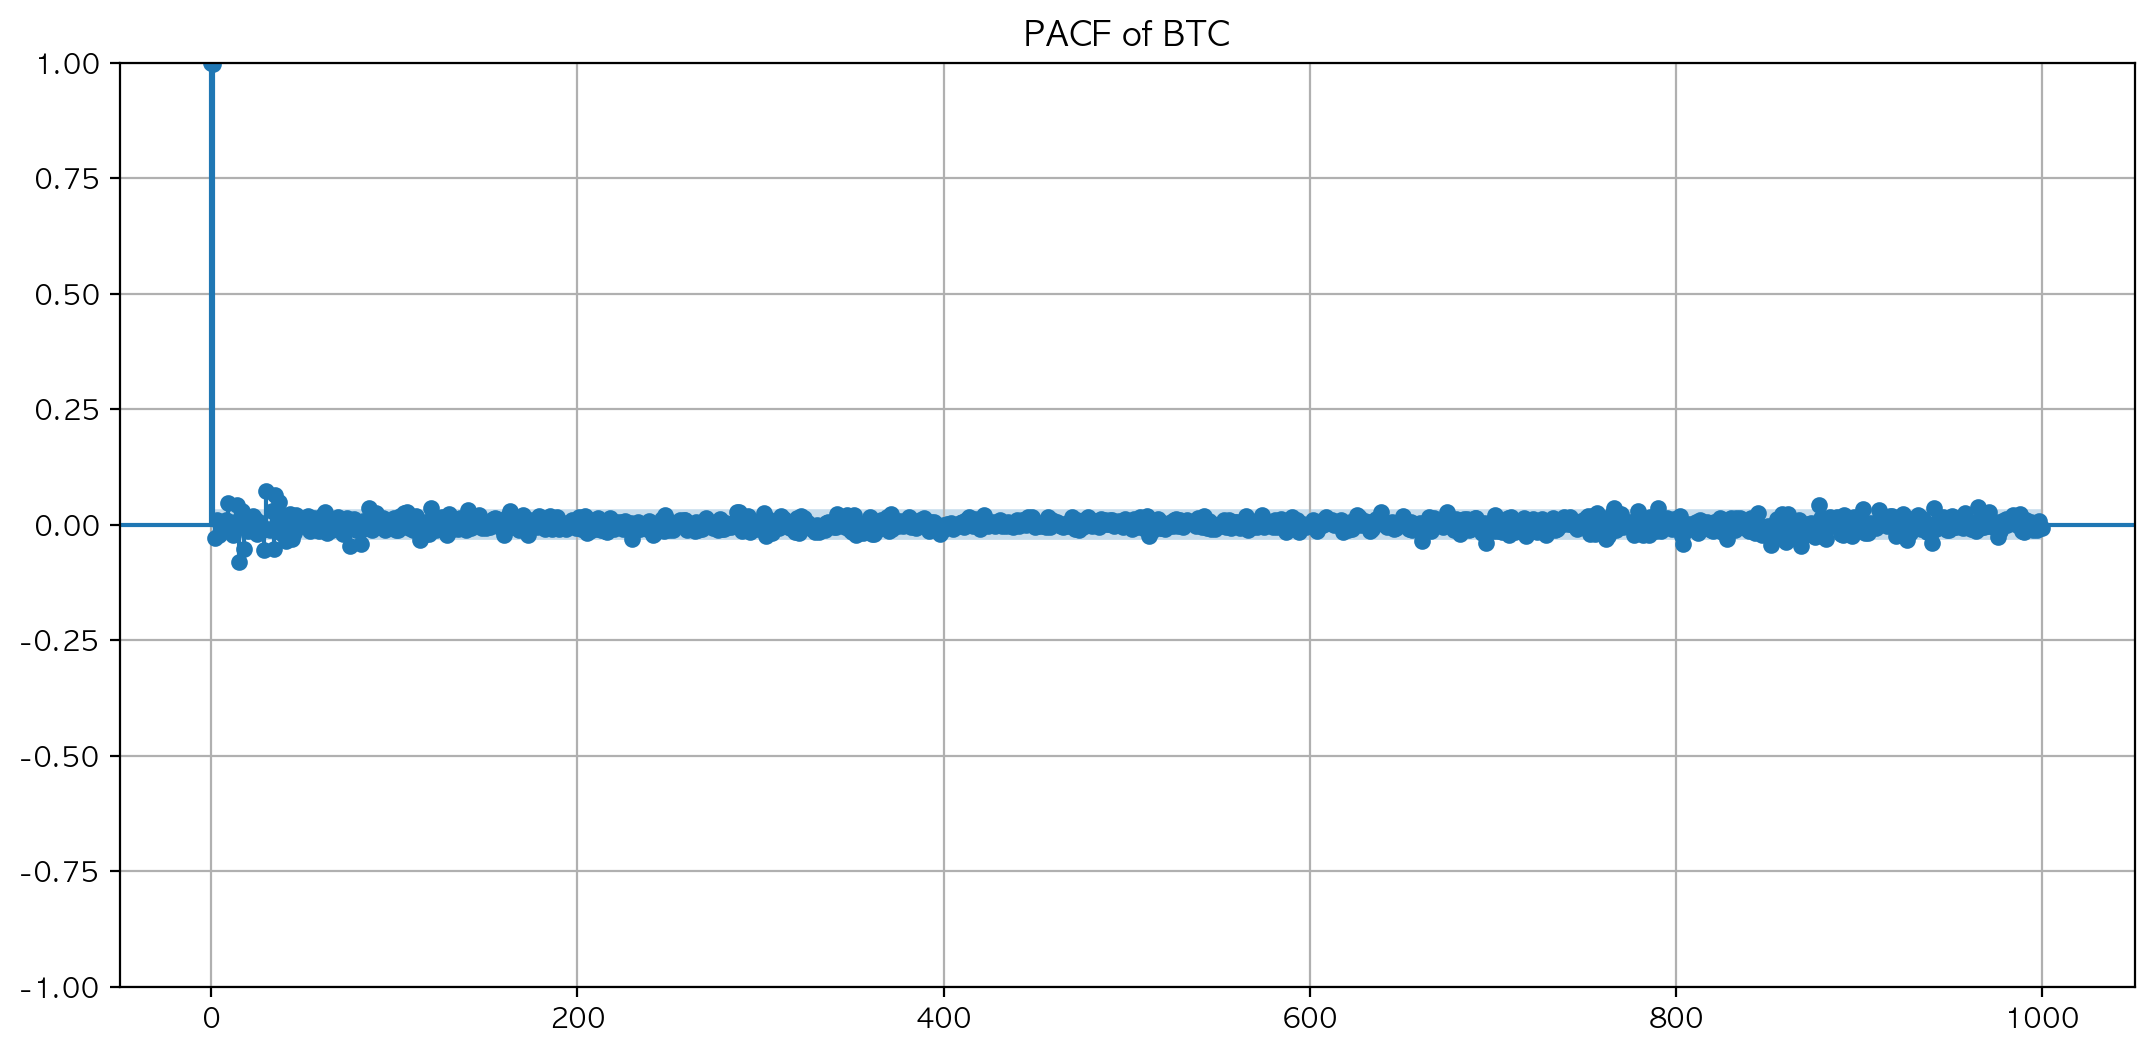

In [20]:
plot_acf(btc, lags = 1000, alpha = 0.05)
plt.title('ACF of BTC')
plt.grid(True)
plot_pacf(btc, lags = 1000)
plt.title('PACF of BTC')
plt.grid(True)
plt.show()

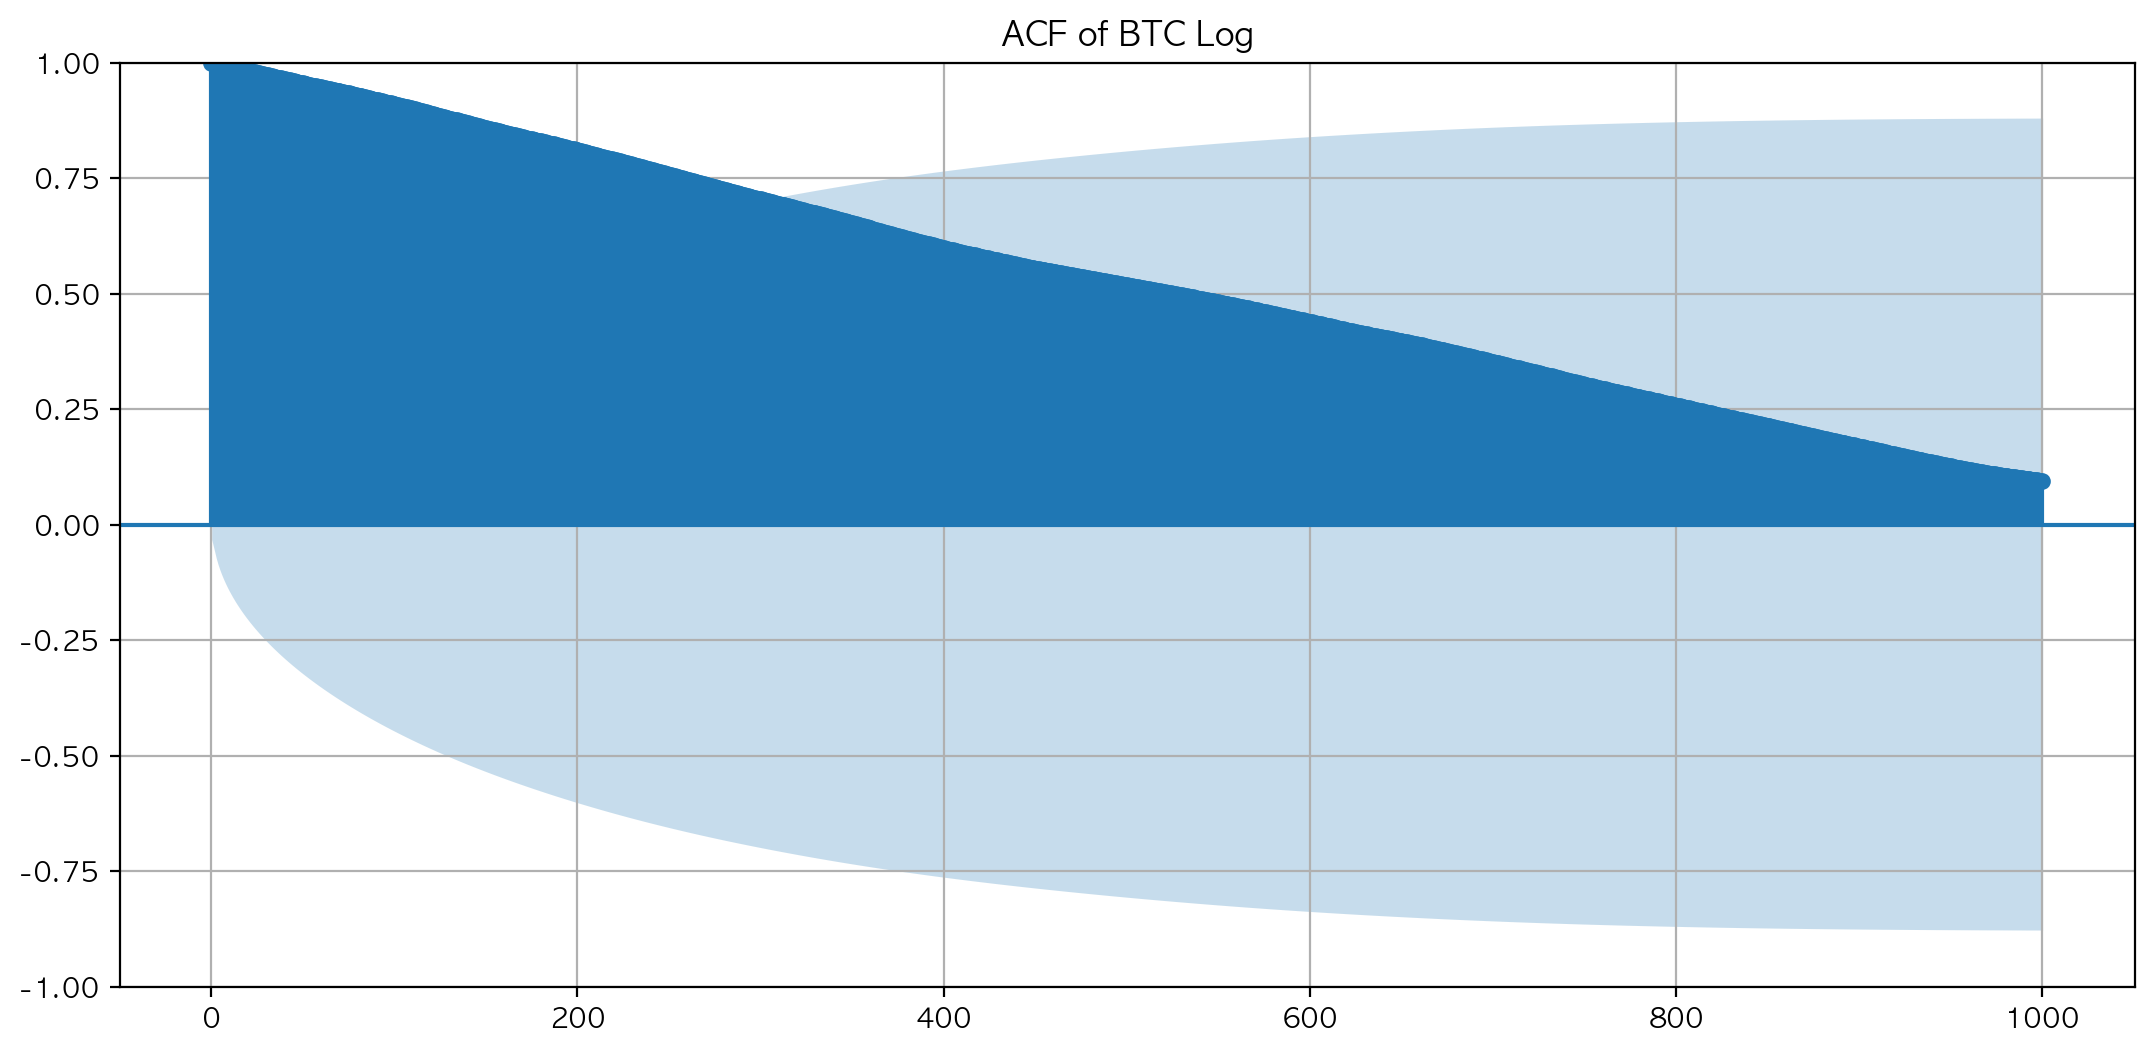

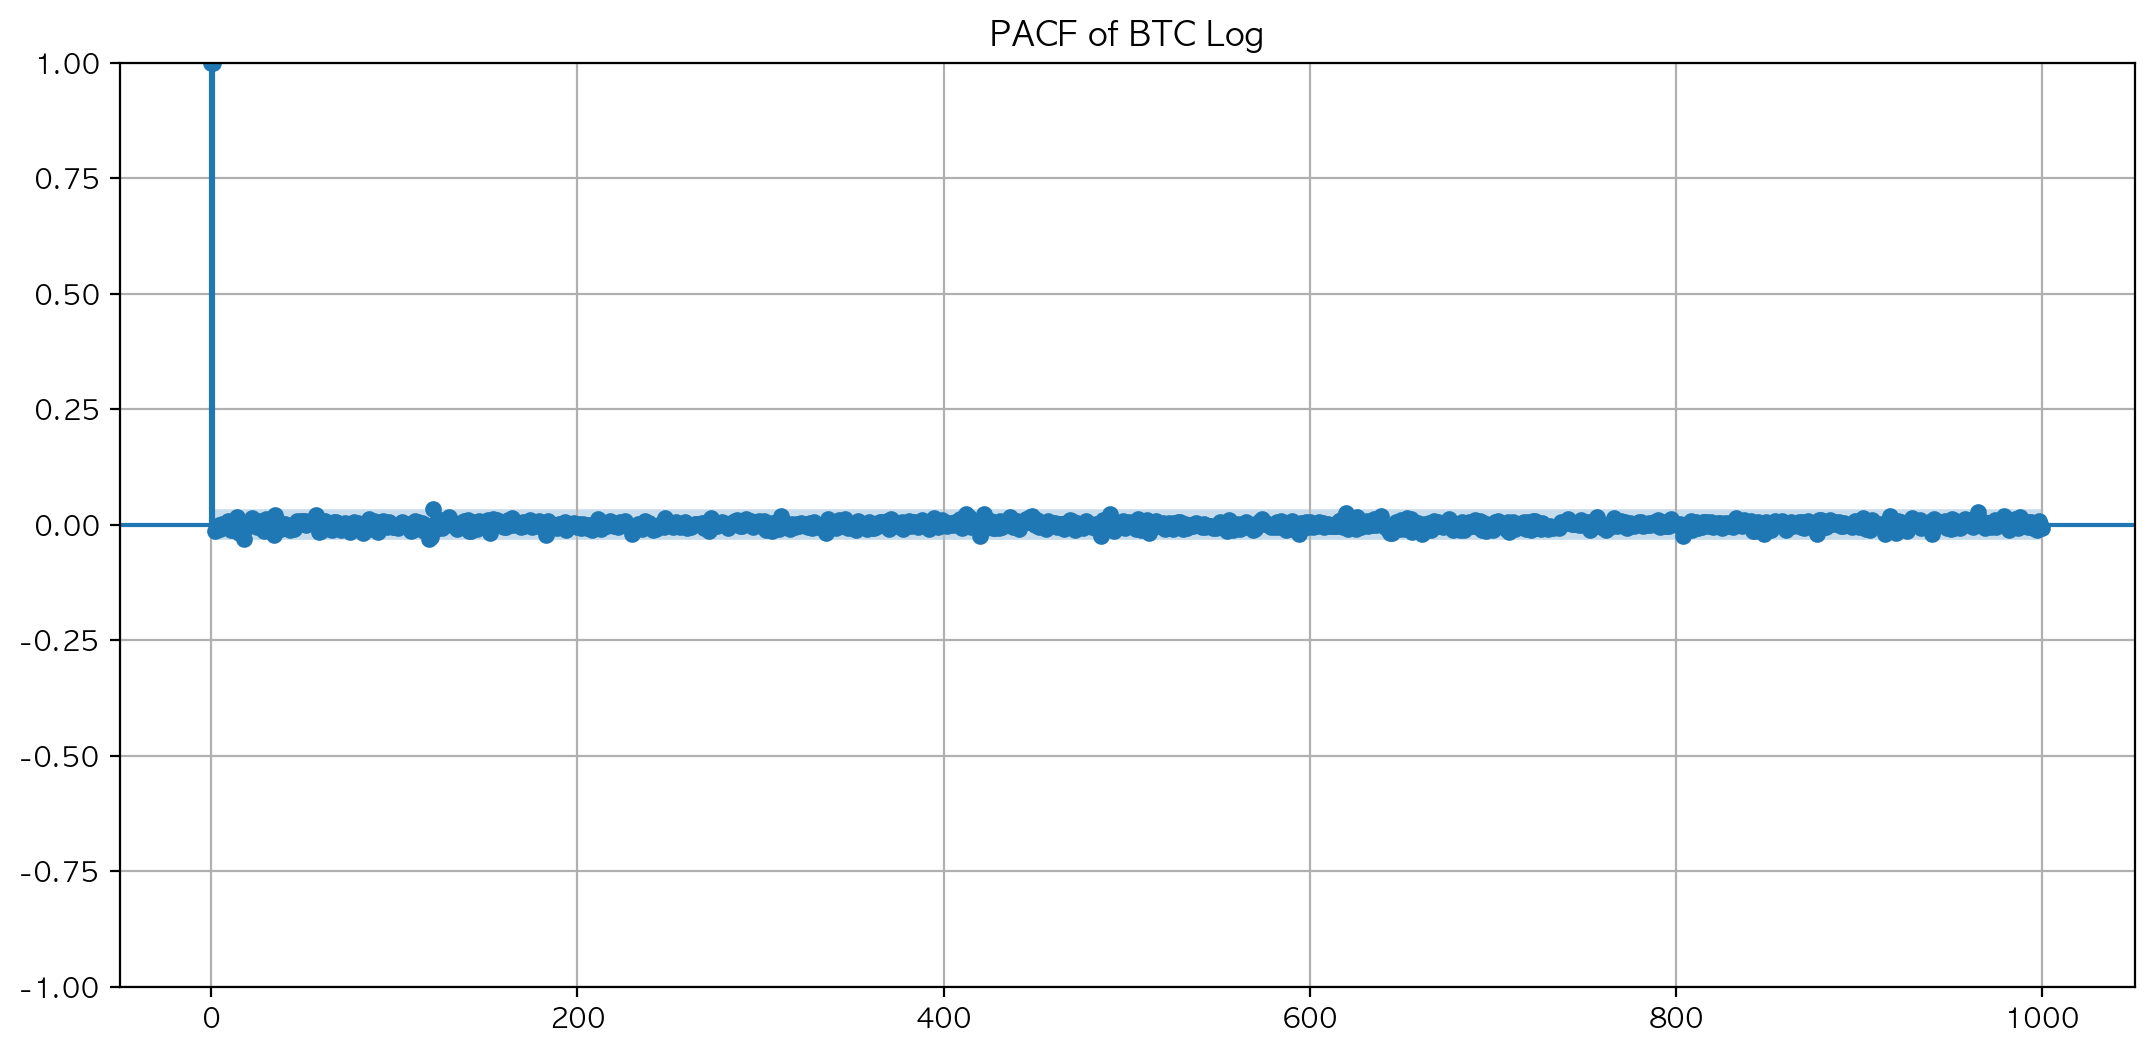

In [21]:
plot_acf(btc_log, lags = 1000, alpha = 0.05)
plt.title('ACF of BTC Log')
plt.grid(True)
plot_pacf(btc_log, lags = 1000)
plt.title('PACF of BTC Log')
plt.grid(True)

## 9- Differencing

Results of Dickey-Fuller Test:
Test Statistic                -1.795697e+01
p-value                        2.825655e-30
#Lags Used                     9.000000e+00
Number of Observations Used    3.475000e+03
Critical Value (1%)           -3.432233e+00
Critical Value (5%)           -2.862372e+00
Critical Value (10%)          -2.567213e+00
dtype: float64


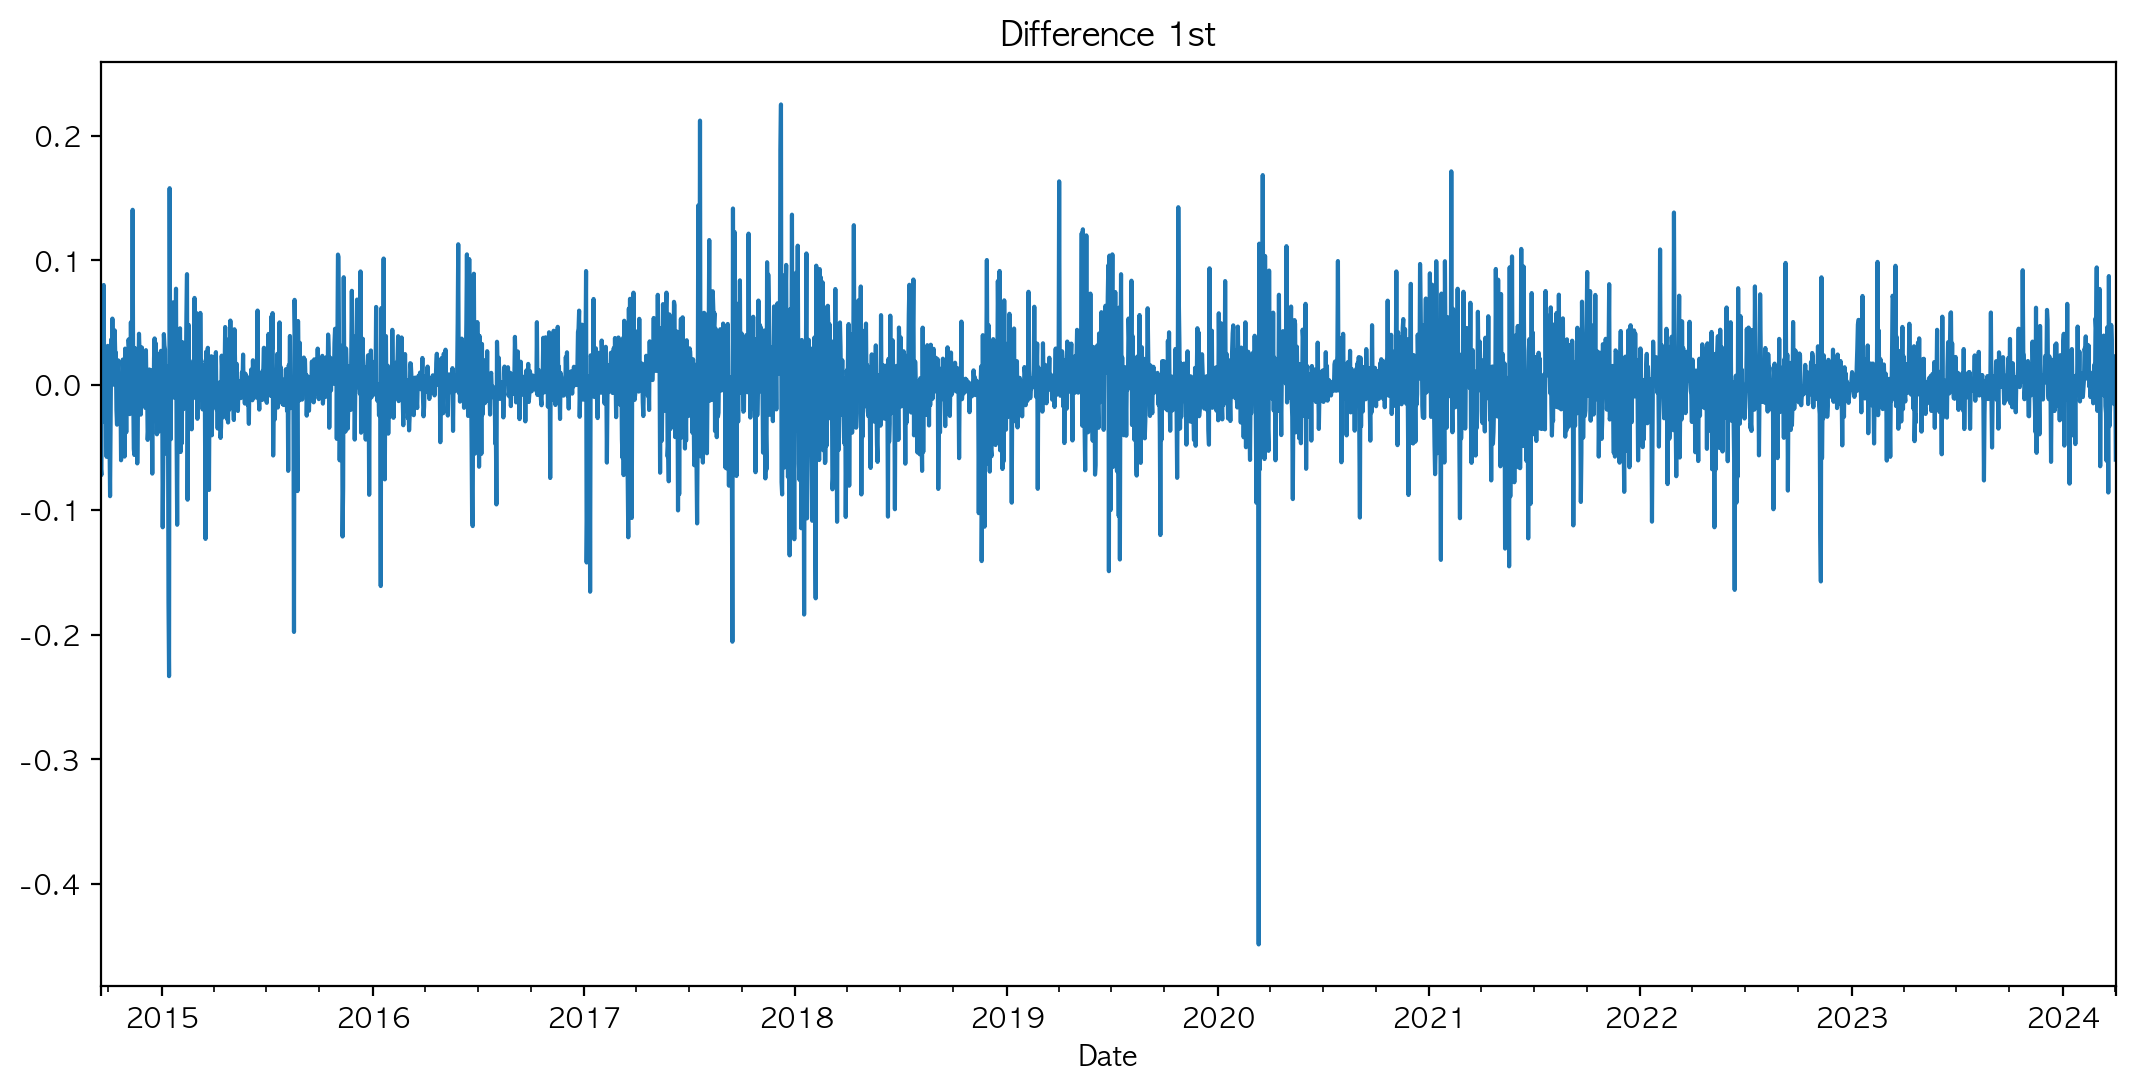

In [22]:
btc_log_diff_1 = btc_log.diff(periods=1).iloc[1:]
btc_log_diff_1.plot(title='Difference 1st')

adf_ts(btc_log_diff_1)

## 10- Split dataset train & test

In [23]:
print(type(btc_log_diff_1))
btc_log_diff_1.head()

<class 'pandas.core.series.Series'>


Date
2014-09-18   -0.066366
2014-09-19   -0.072162
2014-09-20    0.035111
2014-09-21   -0.024968
2014-09-22    0.004910
Name: Close, dtype: float64

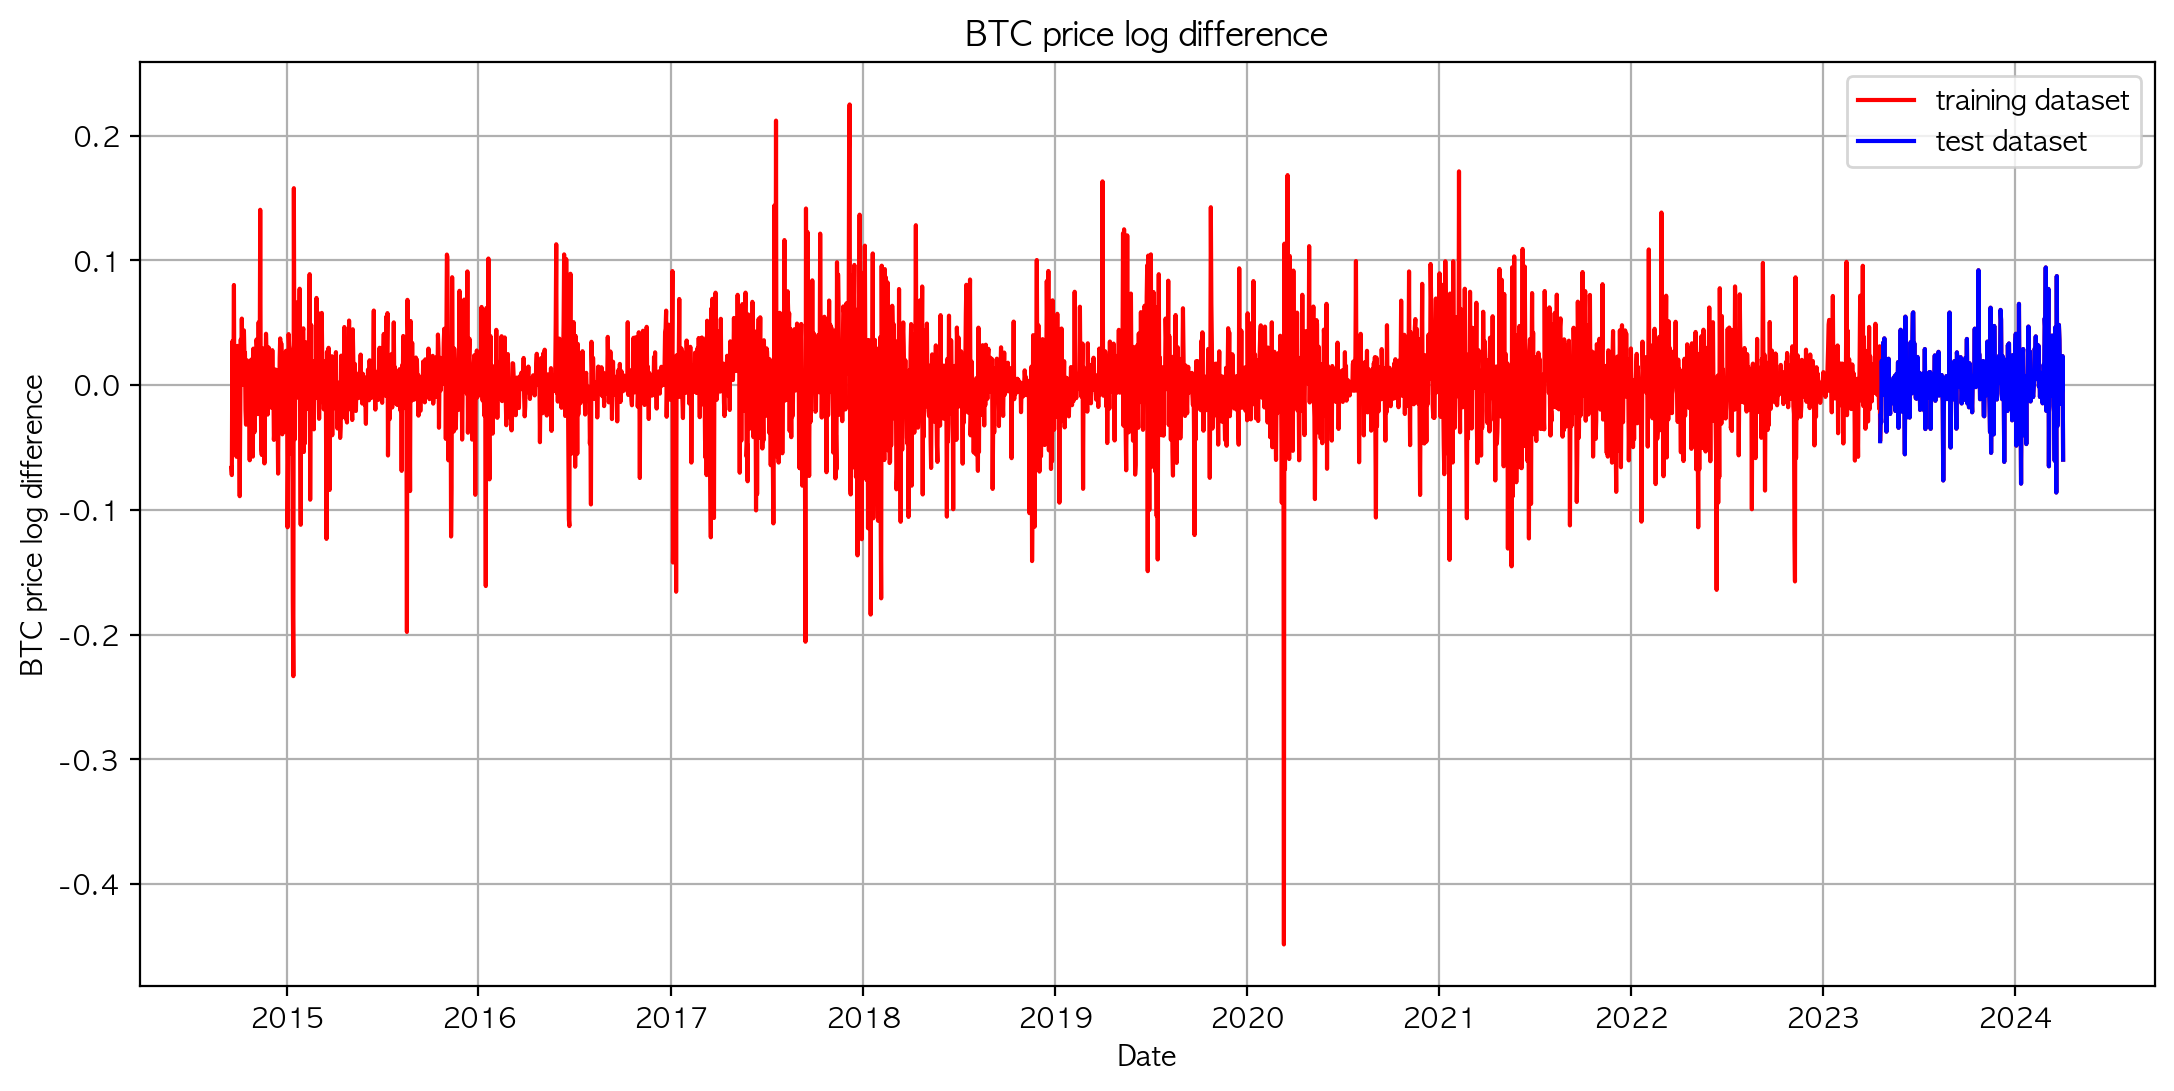

In [24]:
train_data, test_data = btc_log_diff_1[:int(len(btc_log_diff_1)*0.9)], btc_log_diff_1[int(len(btc_log_diff_1)*0.9):]
plt.plot(btc_log_diff_1, c='r', label='training dataset')  # Used ts_log instead of train_data for better visualization
plt.plot(test_data, c='b', label='test dataset')
plt.title('BTC price log difference')
plt.xlabel('Date')
plt.ylabel('BTC price log difference')
plt.legend()
plt.grid(True)

In [25]:
print(train_data.shape, test_data.shape)

(3136,) (349,)


## 11- ARIMA model training

In [27]:
# Define the ARIMA model
model = ARIMA(train_data, order=(1, 2, 2))  

# Fit the ARIMA model
fitted_m = model.fit() 
tqdm(desc='training SARIMA model')

print(fitted_m.summary())

training SARIMA model: 0it [00:00, ?it/s]

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3136
Model:                 ARIMA(1, 2, 2)   Log Likelihood                5777.414
Date:                Tue, 02 Apr 2024   AIC                         -11546.828
Time:                        16:36:31   BIC                         -11522.627
Sample:                    09-18-2014   HQIC                        -11538.142
                         - 04-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0182      0.012     -1.573      0.116      -0.041       0.004
ma.L1         -1.9900      0.002   -907.402      0.000      -1.994      -1.986
ma.L2          0.9900      0.002    451.272      0.0

## 12- Predicting

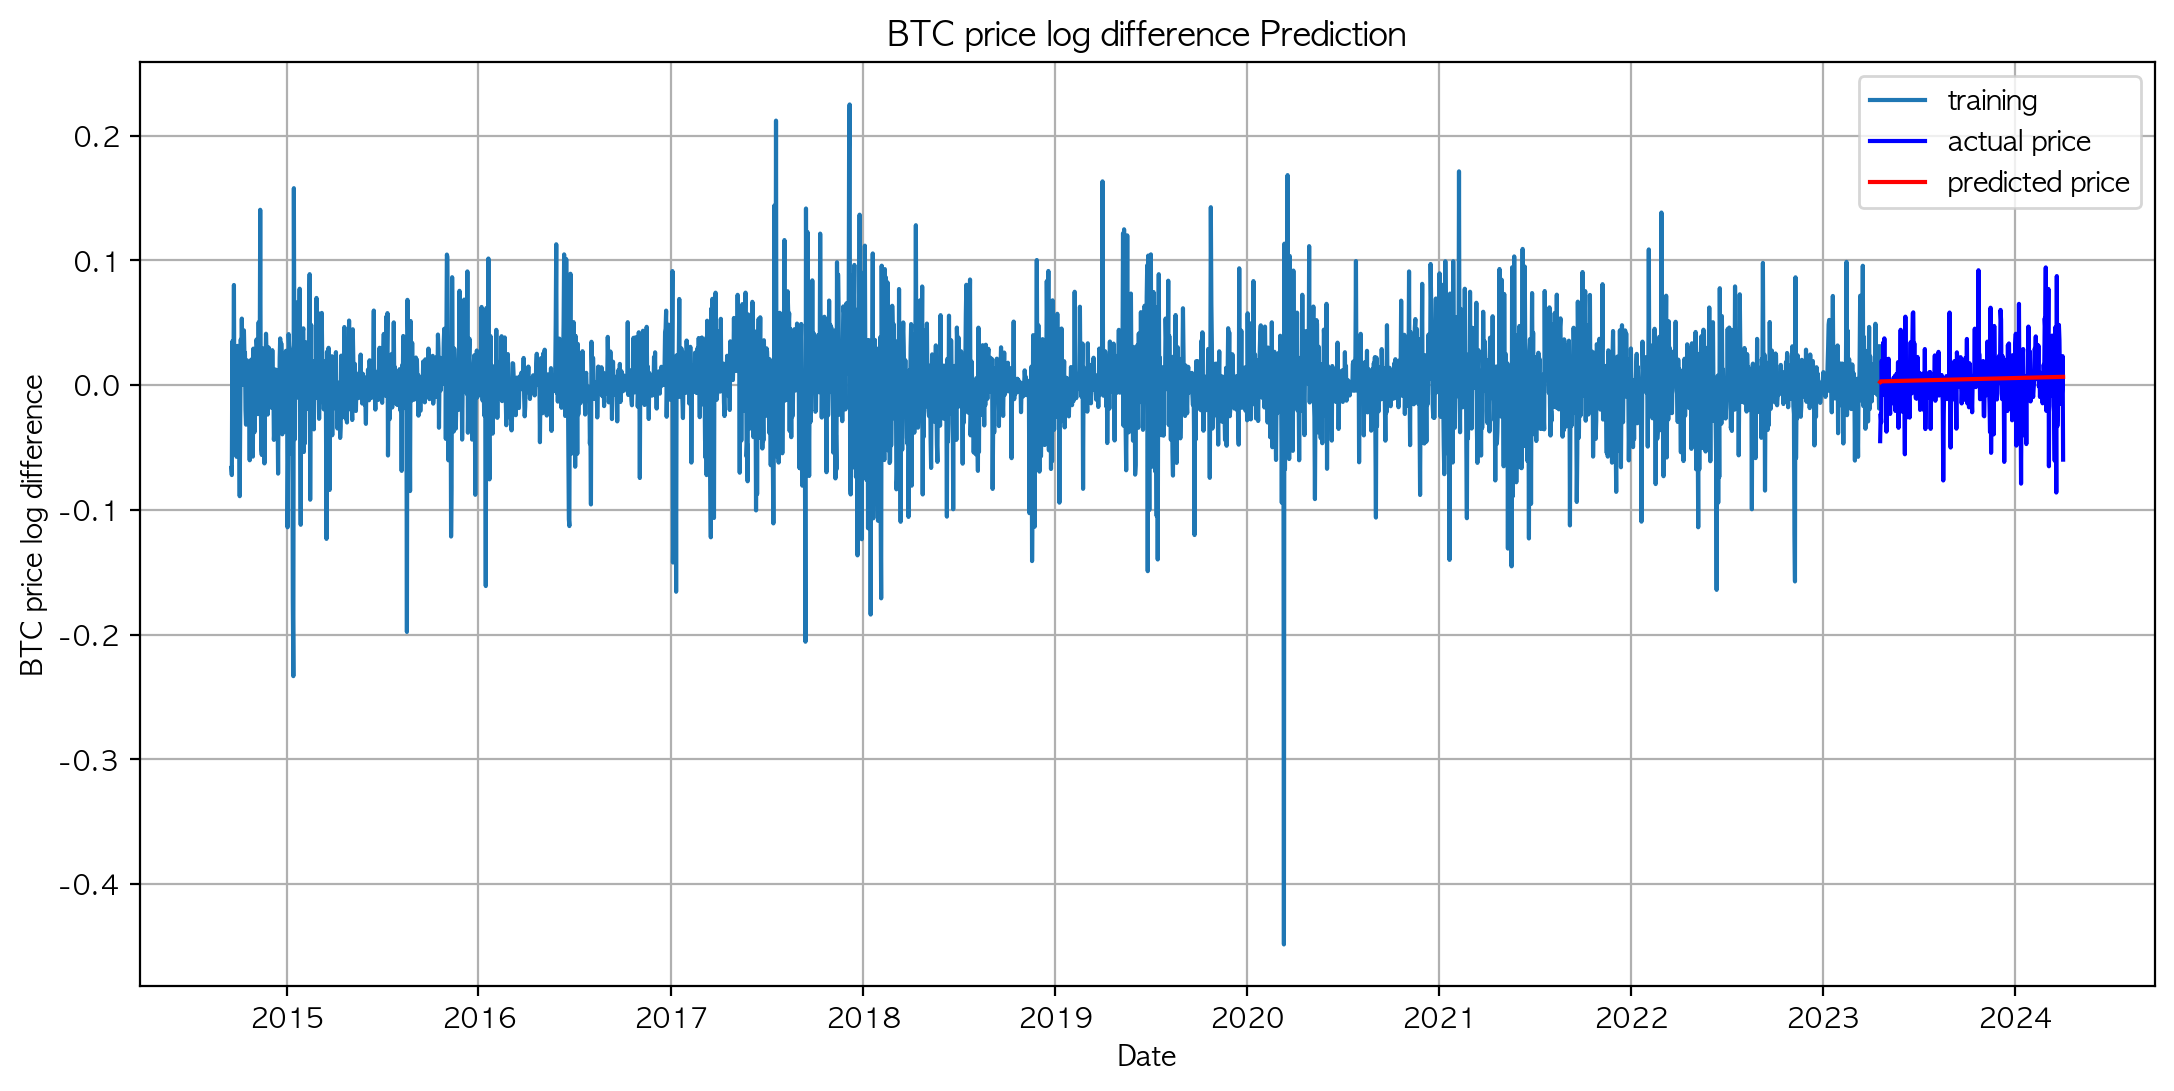

In [28]:
# Forecast in future time
forecast = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
forecast = np.array(forecast)
# Make as pandas series
forecast_series = pd.Series(forecast, index=test_data.index)   # Forecasting data

# Plot
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(forecast_series, c='r',label='predicted price')
plt.title('BTC price log difference Prediction')
plt.xlabel('Date')
plt.ylabel('BTC price log difference')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Reverse the differencing function
def rev_diff(original_log_values, forecast, split_ratio):

    # Calculate the last index for the training data based on the provided split ratio
    last_train_index = int(len(original_log_values) * split_ratio) - 1

    # Extract the last value of the training data from the original logged values
    last_train_value = original_log_values[last_train_index]
    
    # Reverse the differencing process & convert to pandas series
    reversed_forecast = np.r_[last_train_value, forecast].cumsum()[1:]
    reversed_forecast = pd.Series(reversed_forecast, index=test_data.index)

    return reversed_forecast
    # return last_train_index, last_train_value

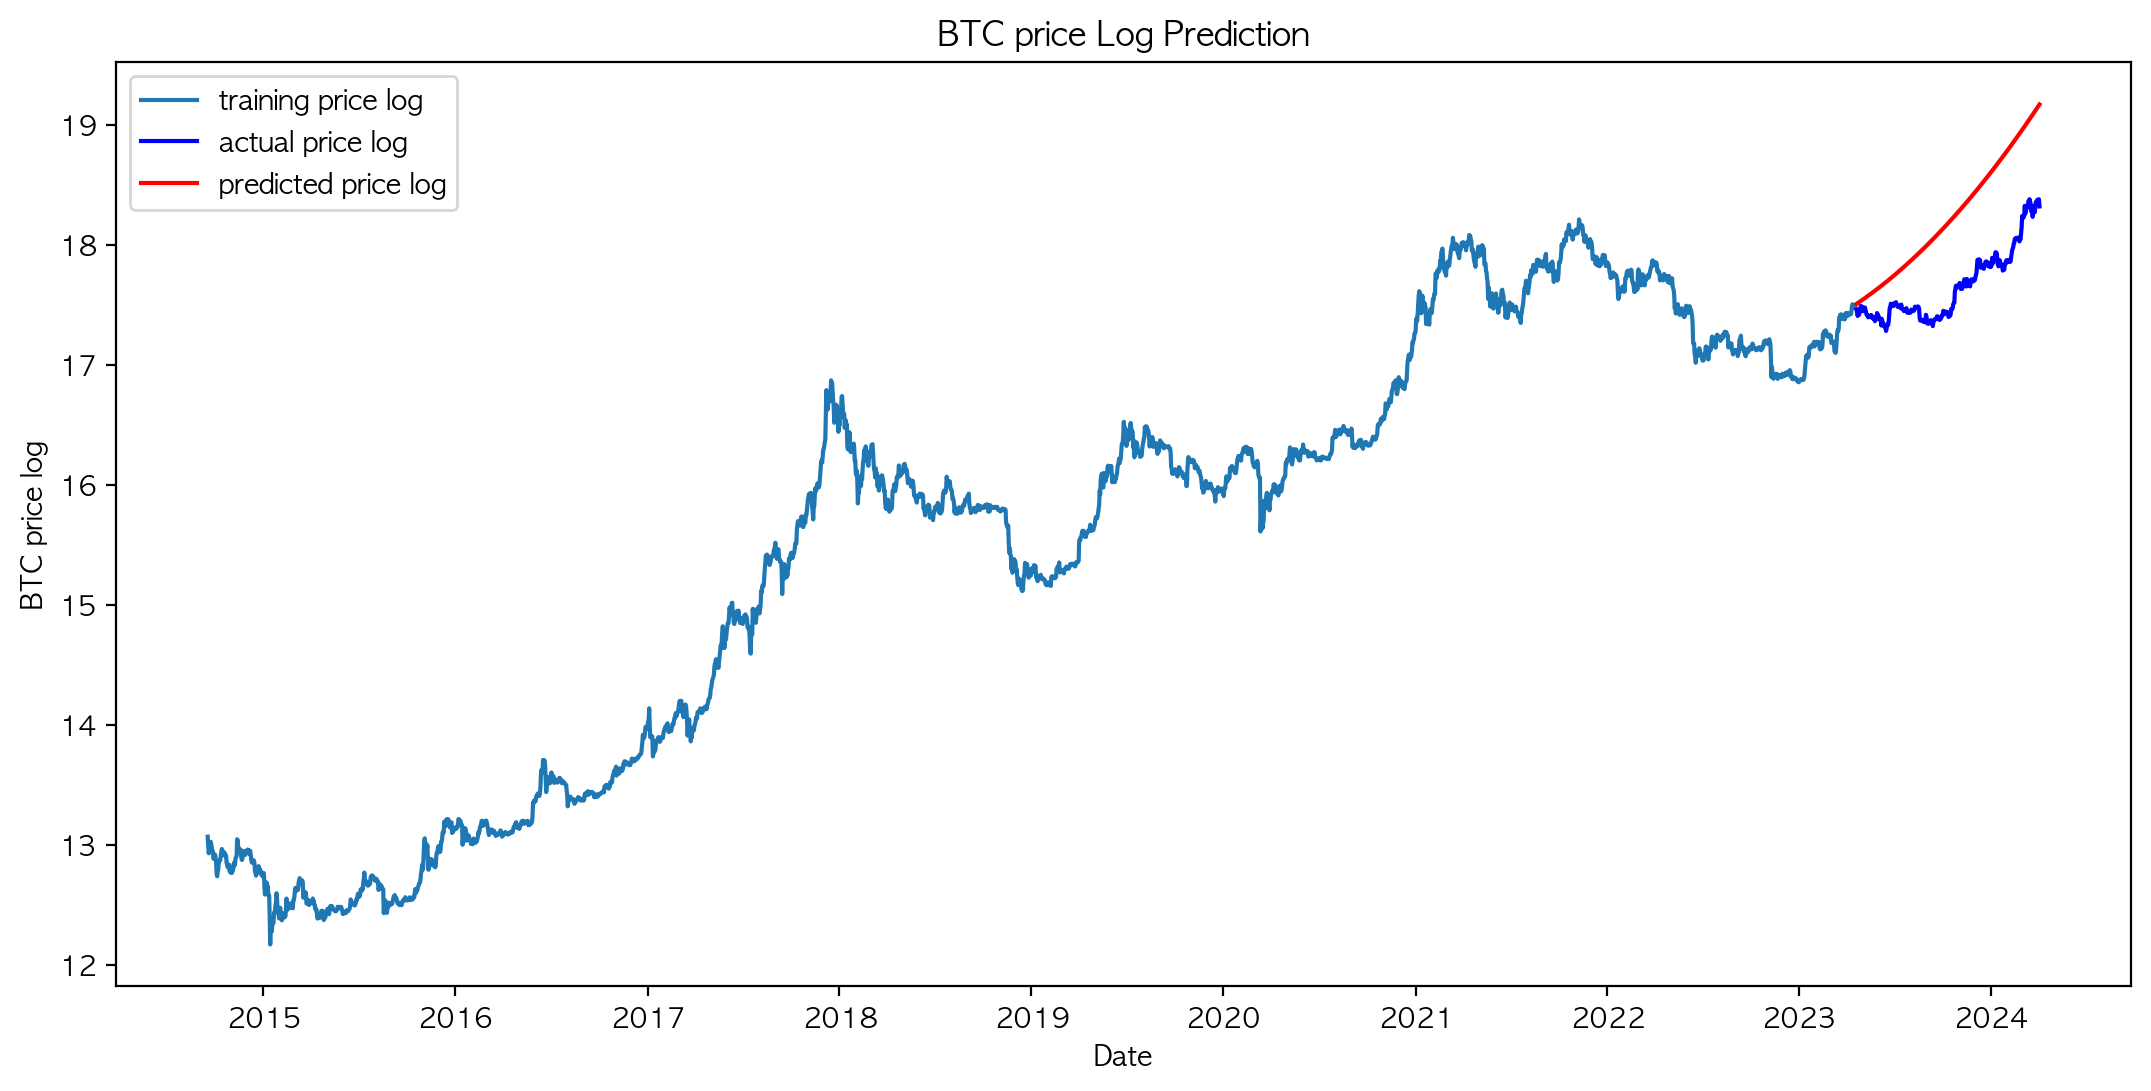

In [30]:
# Reverse the differencing process
train_log = btc_log[:int(len(btc_log_diff_1)*0.9)]
test_log = btc_log[int(len(btc_log_diff_1)*0.9)+1:]
forecast_log = rev_diff(btc_log, forecast, 0.9)

# Plot log values of train, test, and forecast data
plt.plot(train_log, label='training price log')
plt.plot(test_log, label='actual price log', c='b')
plt.plot(forecast_log, label='predicted price log', c='r')
plt.title('BTC price Log Prediction')
plt.xlabel('Date')
plt.ylabel('BTC price log')
plt.legend()

## 13- Evaluation

In [31]:
print(train_data.shape, test_data.shape)
print(train_log.shape, test_log.shape, forecast_log.shape)

(3136,) (349,)
(3136,) (349,) (349,)


In [32]:
# train_log = btc_log[:int(len(btc_log_diff_1)*0.9)]
# test_log = btc_log[int(len(btc_log_diff_1)*0.9):]
# forecast_log = rev_diff(btc_log, forecast, 0.9)

mse = mean_squared_error(np.exp(test_log), np.exp(forecast_log))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_log), np.exp(forecast_log))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_log), np.exp(forecast_log)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(forecast_log) - np.exp(test_log))/np.abs(np.exp(test_log)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2971735820441715.0
MAE:  44522064.40176843
RMSE:  54513629.67590504
MAPE: 83.29%


## 14- Grid search the optimum parameters for ARIMA model

Grid Search Progress: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


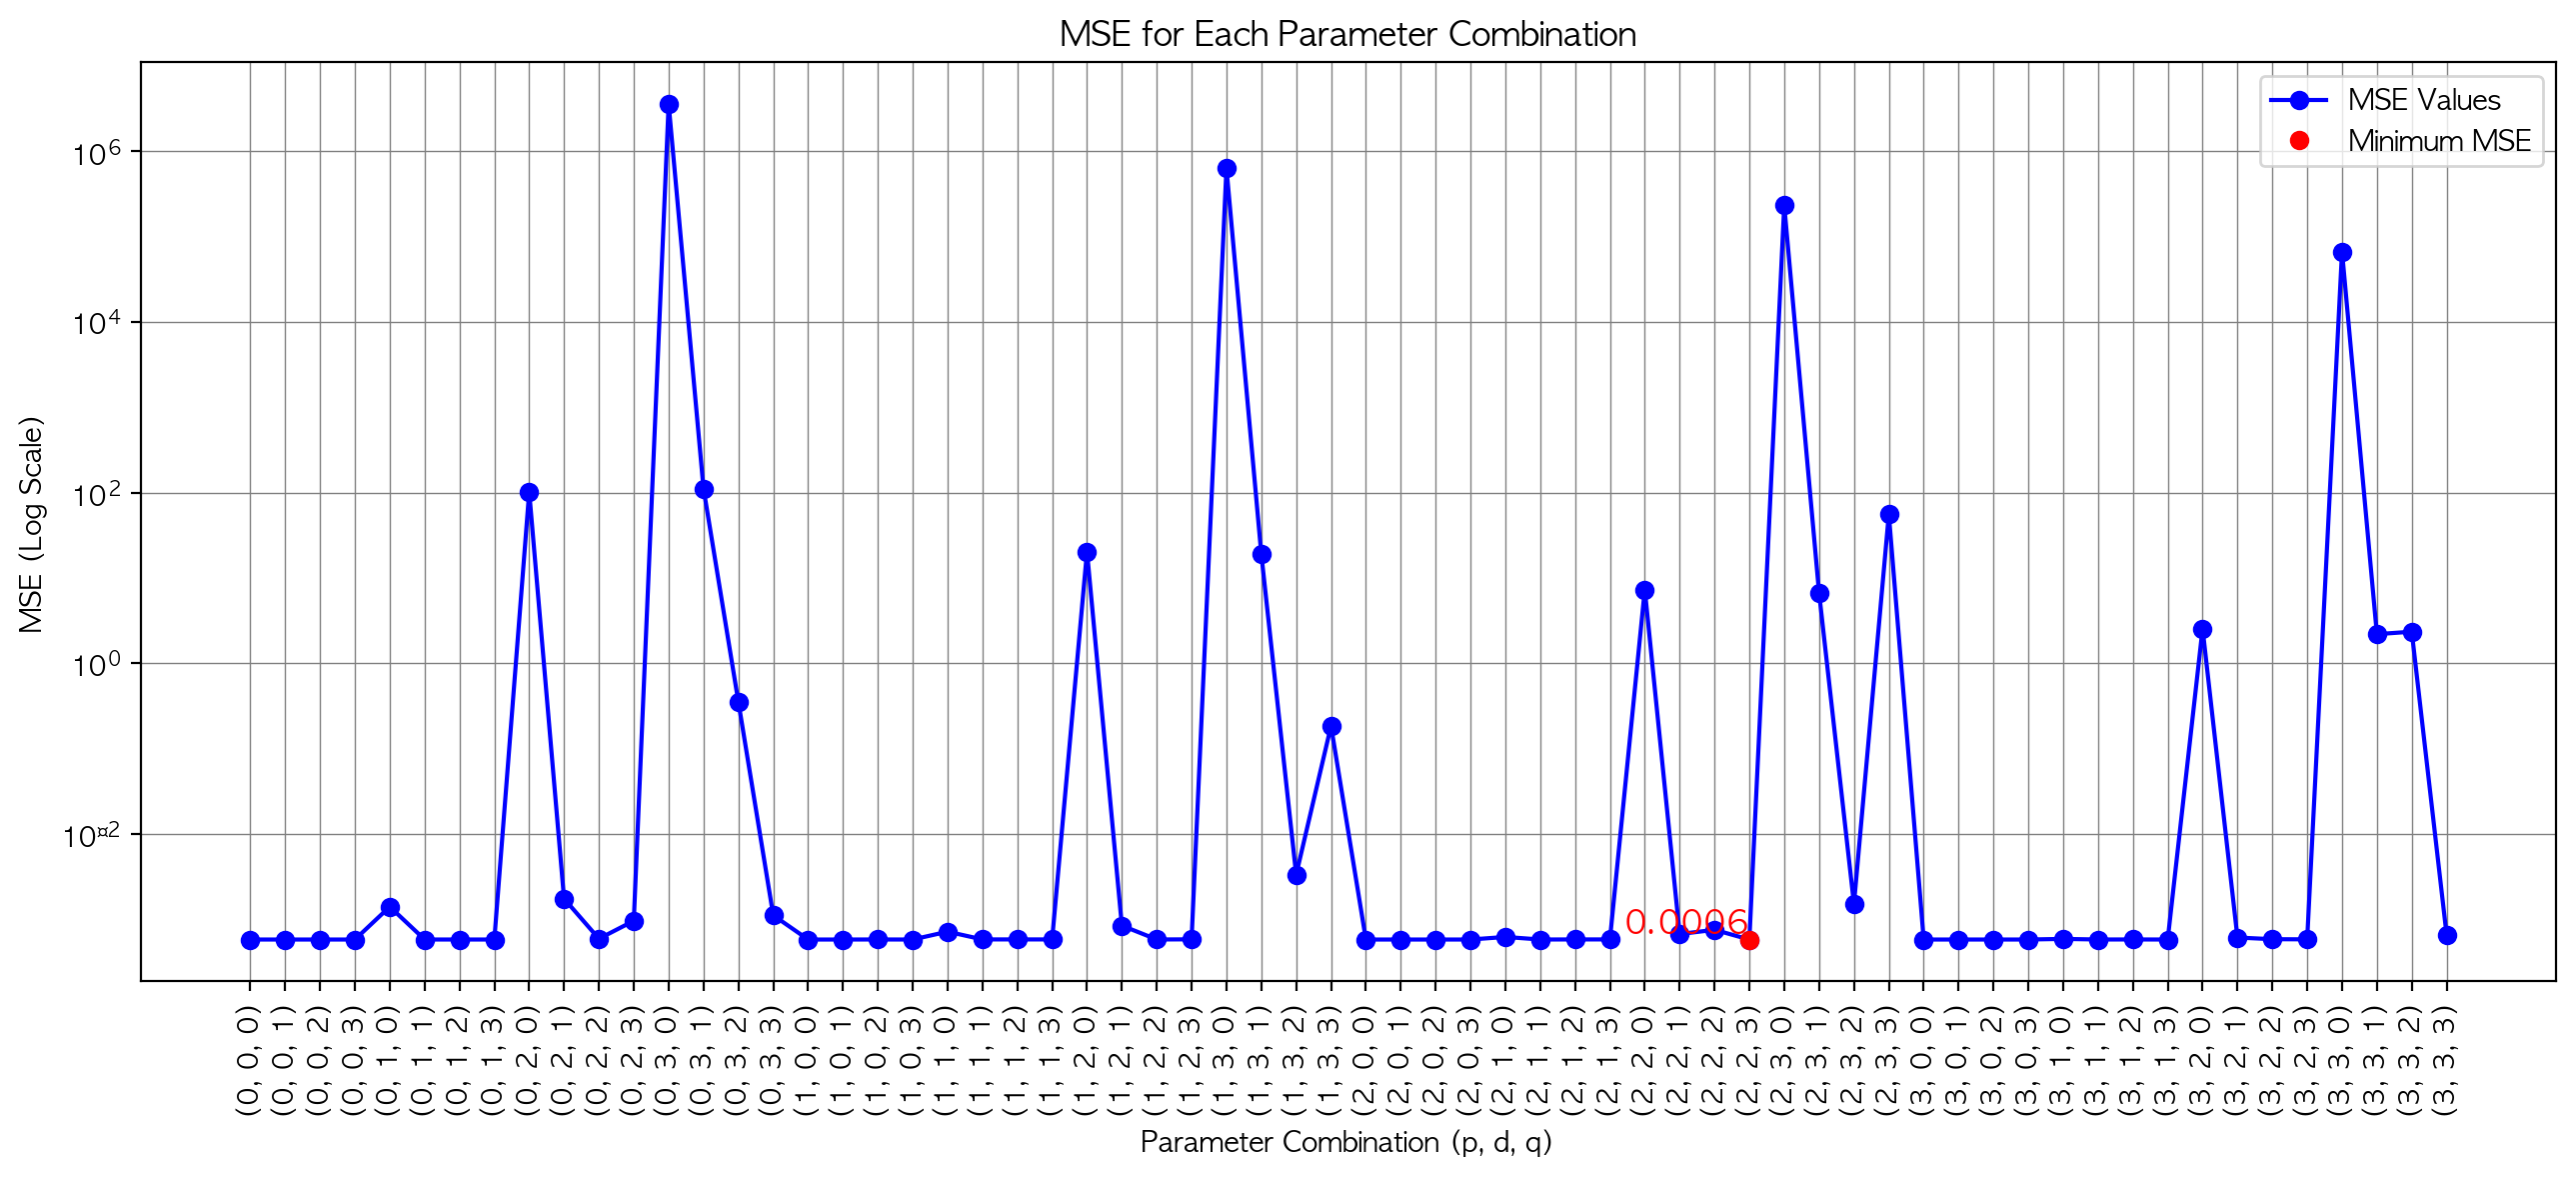

Best ARIMA(2, 2, 3) MSE=0.0006
MSE:  0.0005871093023795268
MAE:  0.016418727167556314
RMSE:  0.024230338470180867
MAPE: 1.63%


In [35]:
## Grid Search for ARIMA Model version 1.0 by Kenny Jung

import itertools  # Library for iteration tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  # Library for ARIMA model
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Library for progress bar
import math

# Define the p, d, q parameters to take any value between numbers
p = d = q = range(0, 4)

# Generate the list of all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define mse, param values, best score, and best cfg
mse_values = []  # Mean Squared Error (MSE) values
param_values = []  # Parameter values
best_score, best_cfg = float("inf"), None  # Best score and best configuration

# Iterate over all the paramaters
for param in tqdm(pdq, desc='Grid Search Progress'):
    try:
        model = ARIMA(train_data, order=param)
        fitted_model = model.fit()
        forecast = fitted_model.forecast(len(test_data))
        mse = mean_squared_error(test_data, forecast)
        mse_values.append(mse)
        param_values.append(param)
        
        if mse < best_score:
            best_score, best_cfg = mse, param
    except:
        continue

# Train the best model
model = ARIMA(train_data, order=best_cfg)
fitted_model = model.fit()
forecast = fitted_model.forecast(len(test_data))

# Create a MSE series
mse_series = pd.Series(mse_values, index=[str(p) for p in pdq])

# Find the minimum value and its position (parameter combination) from the MSE series 
min_mse_value = min(mse_values)
min_mse_index = mse_values.index(min_mse_value)
min_mse_param = param_values[min_mse_index]

# Plot a line graph for all MSE values
plt.plot(mse_series.index, mse_values, 'b-', marker='o', label='MSE Values')

# Highlight the minimum MSE value with a red marker
plt.plot(mse_series.index[min_mse_index], min_mse_value, 'ro', label='Minimum MSE')

# Add text for the minimum MSE value (with an offset proportional to min_mse_value for y position adjustment) 
plt.text(mse_series.index[min_mse_index], min_mse_value, f'{min_mse_value:.4f}', rotation=0, ha='right', va='bottom', color='red', fontsize=12)

# Set the title, labels, and legend
plt.title('MSE for Each Parameter Combination')
plt.xlabel('Parameter Combination (p, d, q)')
plt.xticks(rotation=90, fontsize=10)  
plt.ylabel('MSE (Log Scale)')
plt.yscale('log') 
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.legend()
plt.tight_layout()
plt.show()

# Print the best parameters
print('Best ARIMA%s MSE=%.4f' % (best_cfg, best_score))

# Print MSE, MAE, RMSE, MAPE values
mse = mean_squared_error(np.exp(test_data), np.exp(forecast))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(forecast))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(forecast)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(forecast) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


## 15- SARIMA model training

In [236]:
# Define the SARIMA model
model = SARIMAX(train_data, order=(2, 0, 0), seasonal_order=(1, 1, 2, 365))

# Fit the SARIMA model
# fitted_m = model.fit(disp=False)
tqdm(fitted_m = model.fit(disp=False), desc='training SARIMA model')

print(fitted_m.summary())

## 16- Predicting

In [ ]:
# Forecast in future time
forecast = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
forecast = np.array(forecast)
# Make as pandas series
forecast_series = pd.Series(forecast, index=test_data.index)   # Forecasting data

# Plot
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(forecast_series, c='r',label='predicted price')
plt.title('BTC price log difference Prediction')
plt.xlabel('Date')
plt.ylabel('BTC price log difference')
plt.legend()
plt.grid(True)
plt.show()